In [1]:
import torch
print(torch.__version__)

2.7.1+cu118


In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import math

# ==================================================
# 1. 数据加载和词表构建
# ==================================================
def read_wikitext(path):
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        if line.strip() and not line.startswith('='):
            tokens += line.strip().split()
    return tokens

train_tokens = read_wikitext('C:/Users/zfy/wikitext-2/wiki.train.txt')
valid_tokens = read_wikitext('C:/Users/zfy/wikitext-2/wiki.valid.txt')
test_tokens  = read_wikitext('C:/Users/zfy/wikitext-2/wiki.test.txt')

vocab = ['<unk>'] + [w for w, _ in Counter(train_tokens).most_common(30000)]
stoi = {w: i for i, w in enumerate(vocab)}
itos = {i: w for w, i in stoi.items()}

def encode(tokens): return [stoi.get(t, 0) for t in tokens]
def decode(ids): return [itos[i] for i in ids]

train_ids = torch.tensor(encode(train_tokens), dtype=torch.long)
valid_ids = torch.tensor(encode(valid_tokens), dtype=torch.long)
test_ids  = torch.tensor(encode(test_tokens), dtype=torch.long)

# ==================================================
# 2. 构建 Dataset
# ==================================================
class LMBlockDataset(Dataset):
    def __init__(self, data, block_size=64):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.block_size]
        y = self.data[idx+1:idx+self.block_size+1]
        return x, y

train_ds = LMBlockDataset(train_ids)
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)

# ==================================================
# 3. 定义 Transformer 模型
# ==================================================
class TransformerLM(nn.Module):
    def __init__(self, vocab_size, embed_dim=512, nhead=8, nlayers=6):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_embed = nn.Embedding(5000, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(embed_dim, nhead, dim_feedforward=2048)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.lm_head = nn.Linear(embed_dim, vocab_size)
    
    def forward(self, x):
        seq_len = x.size(1)
        pos = torch.arange(seq_len, device=x.device).unsqueeze(0)
        x = self.embed(x) + self.pos_embed(pos)
        x = self.transformer(x)
        return self.lm_head(x)

# ==================================================
# 4. 训练循环
# ==================================================
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = TransformerLM(len(vocab), embed_dim=128, nhead=4, nlayers=2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

for epoch in range(3):
    model.train()
    total_loss = 0
    for i, (x, y) in enumerate(train_dl):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if i % 200 == 0:
            print(f"epoch {epoch} step {i}: loss={loss.item():.4f}")
    print(f"Epoch {epoch} done, avg loss={total_loss/len(train_dl):.4f}")


D:\APP\Anaconda3\env\py310\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


epoch 0 step 0: loss=10.5173
epoch 0 step 200: loss=6.9807
epoch 0 step 400: loss=7.0722
epoch 0 step 600: loss=6.8355
epoch 0 step 800: loss=6.6994
epoch 0 step 1000: loss=6.4057
epoch 0 step 1200: loss=6.3837
epoch 0 step 1400: loss=6.3505
epoch 0 step 1600: loss=6.3443
epoch 0 step 1800: loss=6.2442
epoch 0 step 2000: loss=6.3281
epoch 0 step 2200: loss=6.2158
epoch 0 step 2400: loss=6.2874
epoch 0 step 2600: loss=6.2615
epoch 0 step 2800: loss=6.1143
epoch 0 step 3000: loss=6.0999
epoch 0 step 3200: loss=6.1278
epoch 0 step 3400: loss=6.1864
epoch 0 step 3600: loss=6.1406
epoch 0 step 3800: loss=6.6104
epoch 0 step 4000: loss=5.7934
epoch 0 step 4200: loss=6.1880
epoch 0 step 4400: loss=5.8142
epoch 0 step 4600: loss=5.8295
epoch 0 step 4800: loss=6.0067
epoch 0 step 5000: loss=5.7567
epoch 0 step 5200: loss=5.8175
epoch 0 step 5400: loss=6.0151
epoch 0 step 5600: loss=6.0873
epoch 0 step 5800: loss=6.0171
epoch 0 step 6000: loss=6.2229
epoch 0 step 6200: loss=5.8989
epoch 0 step 6

In [19]:
train_tokens[0:50]

['=',
 'Valkyria',
 'Chronicles',
 'III',
 '=',
 'Senjō',
 'no',
 'Valkyria',
 '3',
 ':',
 '<unk>',
 'Chronicles',
 '(',
 'Japanese',
 ':',
 '戦場のヴァルキュリア3',
 ',',
 'lit',
 '.',
 'Valkyria',
 'of',
 'the',
 'Battlefield',
 '3',
 ')',
 ',',
 'commonly',
 'referred',
 'to',
 'as',
 'Valkyria',
 'Chronicles',
 'III',
 'outside',
 'Japan',
 ',',
 'is',
 'a',
 'tactical',
 'role',
 '@-@',
 'playing',
 'video',
 'game',
 'developed',
 'by',
 'Sega',
 'and',
 'Media.Vision',
 'for']

In [23]:
train_ids[2]

tensor(4419)

In [24]:
len(vocab)

30001

In [25]:
model.embed.weight.shape

torch.Size([30001, 128])

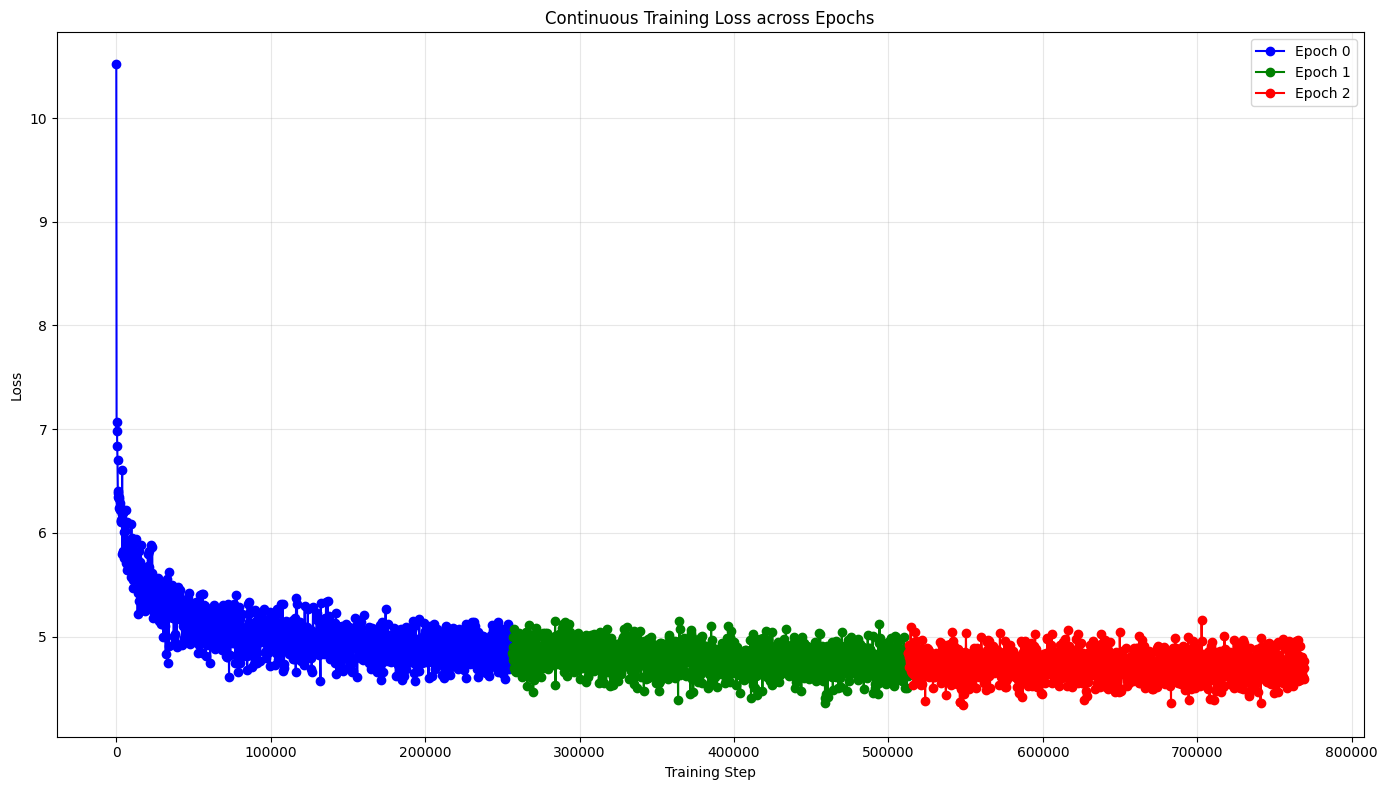

In [15]:
import re
import matplotlib.pyplot as plt

# 示例：你的日志数据（你可以替换为读取文件）
log_data = """
epoch 0 step 0: loss=10.5173
epoch 0 step 200: loss=6.9807
epoch 0 step 400: loss=7.0722
epoch 0 step 600: loss=6.8355
epoch 0 step 800: loss=6.6994
epoch 0 step 1000: loss=6.4057
epoch 0 step 1200: loss=6.3837
epoch 0 step 1400: loss=6.3505
epoch 0 step 1600: loss=6.3443
epoch 0 step 1800: loss=6.2442
epoch 0 step 2000: loss=6.3281
epoch 0 step 2200: loss=6.2158
epoch 0 step 2400: loss=6.2874
epoch 0 step 2600: loss=6.2615
epoch 0 step 2800: loss=6.1143
epoch 0 step 3000: loss=6.0999
epoch 0 step 3200: loss=6.1278
epoch 0 step 3400: loss=6.1864
epoch 0 step 3600: loss=6.1406
epoch 0 step 3800: loss=6.6104
epoch 0 step 4000: loss=5.7934
epoch 0 step 4200: loss=6.1880
epoch 0 step 4400: loss=5.8142
epoch 0 step 4600: loss=5.8295
epoch 0 step 4800: loss=6.0067
epoch 0 step 5000: loss=5.7567
epoch 0 step 5200: loss=5.8175
epoch 0 step 5400: loss=6.0151
epoch 0 step 5600: loss=6.0873
epoch 0 step 5800: loss=6.0171
epoch 0 step 6000: loss=6.2229
epoch 0 step 6200: loss=5.8989
epoch 0 step 6400: loss=5.7142
epoch 0 step 6600: loss=5.9306
epoch 0 step 6800: loss=6.1066
epoch 0 step 7000: loss=5.6386
epoch 0 step 7200: loss=5.8784
epoch 0 step 7400: loss=5.8489
epoch 0 step 7600: loss=5.6788
epoch 0 step 7800: loss=5.8357
epoch 0 step 8000: loss=5.7328
epoch 0 step 8200: loss=5.8544
epoch 0 step 8400: loss=5.8597
epoch 0 step 8600: loss=5.7457
epoch 0 step 8800: loss=5.6927
epoch 0 step 9000: loss=5.7396
epoch 0 step 9200: loss=5.8360
epoch 0 step 9400: loss=5.5765
epoch 0 step 9600: loss=5.8709
epoch 0 step 9800: loss=6.0878
epoch 0 step 10000: loss=5.6411
epoch 0 step 10200: loss=5.9490
epoch 0 step 10400: loss=5.7014
epoch 0 step 10600: loss=5.8393
epoch 0 step 10800: loss=5.5476
epoch 0 step 11000: loss=5.4664
epoch 0 step 11200: loss=5.6826
epoch 0 step 11400: loss=5.8164
epoch 0 step 11600: loss=5.6673
epoch 0 step 11800: loss=5.6332
epoch 0 step 12000: loss=5.5770
epoch 0 step 12200: loss=5.8016
epoch 0 step 12400: loss=5.7236
epoch 0 step 12600: loss=5.8173
epoch 0 step 12800: loss=5.9392
epoch 0 step 13000: loss=5.6581
epoch 0 step 13200: loss=5.6743
epoch 0 step 13400: loss=5.7534
epoch 0 step 13600: loss=5.6598
epoch 0 step 13800: loss=5.2187
epoch 0 step 14000: loss=5.4243
epoch 0 step 14200: loss=5.6001
epoch 0 step 14400: loss=5.4738
epoch 0 step 14600: loss=5.4250
epoch 0 step 14800: loss=5.8298
epoch 0 step 15000: loss=5.3390
epoch 0 step 15200: loss=5.6181
epoch 0 step 15400: loss=5.7232
epoch 0 step 15600: loss=5.5261
epoch 0 step 15800: loss=5.8832
epoch 0 step 16000: loss=5.4890
epoch 0 step 16200: loss=5.4580
epoch 0 step 16400: loss=5.4559
epoch 0 step 16600: loss=5.3096
epoch 0 step 16800: loss=5.2873
epoch 0 step 17000: loss=5.6708
epoch 0 step 17200: loss=5.4365
epoch 0 step 17400: loss=5.3496
epoch 0 step 17600: loss=5.3016
epoch 0 step 17800: loss=5.3522
epoch 0 step 18000: loss=5.4701
epoch 0 step 18200: loss=5.3611
epoch 0 step 18400: loss=5.4505
epoch 0 step 18600: loss=5.2659
epoch 0 step 18800: loss=5.2454
epoch 0 step 19000: loss=5.4151
epoch 0 step 19200: loss=5.2621
epoch 0 step 19400: loss=5.6083
epoch 0 step 19600: loss=5.5863
epoch 0 step 19800: loss=5.5553
epoch 0 step 20000: loss=5.4180
epoch 0 step 20200: loss=5.3407
epoch 0 step 20400: loss=5.7918
epoch 0 step 20600: loss=5.6788
epoch 0 step 20800: loss=5.3218
epoch 0 step 21000: loss=5.8243
epoch 0 step 21200: loss=5.6692
epoch 0 step 21400: loss=5.5606
epoch 0 step 21600: loss=5.4829
epoch 0 step 21800: loss=5.3120
epoch 0 step 22000: loss=5.3266
epoch 0 step 22200: loss=5.8873
epoch 0 step 22400: loss=5.3415
epoch 0 step 22600: loss=5.3907
epoch 0 step 22800: loss=5.2743
epoch 0 step 23000: loss=5.4686
epoch 0 step 23200: loss=5.8606
epoch 0 step 23400: loss=5.6177
epoch 0 step 23600: loss=5.1744
epoch 0 step 23800: loss=5.2472
epoch 0 step 24000: loss=5.4880
epoch 0 step 24200: loss=5.3528
epoch 0 step 24400: loss=5.5533
epoch 0 step 24600: loss=5.3682
epoch 0 step 24800: loss=5.3764
epoch 0 step 25000: loss=5.4466
epoch 0 step 25200: loss=5.2239
epoch 0 step 25400: loss=5.3017
epoch 0 step 25600: loss=5.4480
epoch 0 step 25800: loss=5.2443
epoch 0 step 26000: loss=5.2030
epoch 0 step 26200: loss=5.5332
epoch 0 step 26400: loss=5.5189
epoch 0 step 26600: loss=5.2902
epoch 0 step 26800: loss=5.3989
epoch 0 step 27000: loss=5.5448
epoch 0 step 27200: loss=5.5632
epoch 0 step 27400: loss=5.2275
epoch 0 step 27600: loss=5.1495
epoch 0 step 27800: loss=5.3932
epoch 0 step 28000: loss=5.4579
epoch 0 step 28200: loss=5.3859
epoch 0 step 28400: loss=5.5168
epoch 0 step 28600: loss=5.2586
epoch 0 step 28800: loss=5.1237
epoch 0 step 29000: loss=5.3876
epoch 0 step 29200: loss=5.5074
epoch 0 step 29400: loss=5.2000
epoch 0 step 29600: loss=5.4563
epoch 0 step 29800: loss=5.1581
epoch 0 step 30000: loss=5.1322
epoch 0 step 30200: loss=5.4696
epoch 0 step 30400: loss=4.9918
epoch 0 step 30600: loss=5.3369
epoch 0 step 30800: loss=5.2025
epoch 0 step 31000: loss=5.3176
epoch 0 step 31200: loss=5.2050
epoch 0 step 31400: loss=5.1924
epoch 0 step 31600: loss=5.0994
epoch 0 step 31800: loss=5.1699
epoch 0 step 32000: loss=4.8313
epoch 0 step 32200: loss=5.3077
epoch 0 step 32400: loss=5.2590
epoch 0 step 32600: loss=5.5582
epoch 0 step 32800: loss=5.3125
epoch 0 step 33000: loss=5.3874
epoch 0 step 33200: loss=4.7481
epoch 0 step 33400: loss=5.2809
epoch 0 step 33600: loss=5.4125
epoch 0 step 33800: loss=5.3865
epoch 0 step 34000: loss=4.9070
epoch 0 step 34200: loss=5.2397
epoch 0 step 34400: loss=5.6184
epoch 0 step 34600: loss=5.4653
epoch 0 step 34800: loss=5.3979
epoch 0 step 35000: loss=5.3857
epoch 0 step 35200: loss=5.1930
epoch 0 step 35400: loss=5.2616
epoch 0 step 35600: loss=5.3330
epoch 0 step 35800: loss=5.3592
epoch 0 step 36000: loss=5.4985
epoch 0 step 36200: loss=5.3985
epoch 0 step 36400: loss=5.1792
epoch 0 step 36600: loss=5.1800
epoch 0 step 36800: loss=5.4356
epoch 0 step 37000: loss=5.3749
epoch 0 step 37200: loss=4.9979
epoch 0 step 37400: loss=5.2677
epoch 0 step 37600: loss=5.0029
epoch 0 step 37800: loss=4.9459
epoch 0 step 38000: loss=5.2681
epoch 0 step 38200: loss=5.0223
epoch 0 step 38400: loss=5.4519
epoch 0 step 38600: loss=5.3519
epoch 0 step 38800: loss=5.3642
epoch 0 step 39000: loss=4.9035
epoch 0 step 39200: loss=5.2113
epoch 0 step 39400: loss=5.2600
epoch 0 step 39600: loss=5.2033
epoch 0 step 39800: loss=5.3498
epoch 0 step 40000: loss=5.2346
epoch 0 step 40200: loss=5.4761
epoch 0 step 40400: loss=5.4025
epoch 0 step 40600: loss=5.3767
epoch 0 step 40800: loss=5.4159
epoch 0 step 41000: loss=5.3294
epoch 0 step 41200: loss=5.2538
epoch 0 step 41400: loss=5.4507
epoch 0 step 41600: loss=5.1628
epoch 0 step 41800: loss=5.3063
epoch 0 step 42000: loss=5.1988
epoch 0 step 42200: loss=5.3649
epoch 0 step 42400: loss=5.1982
epoch 0 step 42600: loss=4.9148
epoch 0 step 42800: loss=4.9319
epoch 0 step 43000: loss=5.1057
epoch 0 step 43200: loss=5.3423
epoch 0 step 43400: loss=5.2413
epoch 0 step 43600: loss=5.3418
epoch 0 step 43800: loss=4.9843
epoch 0 step 44000: loss=5.2447
epoch 0 step 44200: loss=5.0817
epoch 0 step 44400: loss=5.3495
epoch 0 step 44600: loss=5.1271
epoch 0 step 44800: loss=5.0166
epoch 0 step 45000: loss=5.1428
epoch 0 step 45200: loss=5.0730
epoch 0 step 45400: loss=5.2731
epoch 0 step 45600: loss=5.0934
epoch 0 step 45800: loss=5.2850
epoch 0 step 46000: loss=5.1959
epoch 0 step 46200: loss=5.1986
epoch 0 step 46400: loss=5.3677
epoch 0 step 46600: loss=5.1098
epoch 0 step 46800: loss=5.4165
epoch 0 step 47000: loss=5.1516
epoch 0 step 47200: loss=4.9472
epoch 0 step 47400: loss=5.0648
epoch 0 step 47600: loss=4.9264
epoch 0 step 47800: loss=5.1677
epoch 0 step 48000: loss=4.9834
epoch 0 step 48200: loss=5.2724
epoch 0 step 48400: loss=5.3154
epoch 0 step 48600: loss=5.1770
epoch 0 step 48800: loss=5.1133
epoch 0 step 49000: loss=5.0008
epoch 0 step 49200: loss=5.2146
epoch 0 step 49400: loss=5.1598
epoch 0 step 49600: loss=5.1962
epoch 0 step 49800: loss=5.1012
epoch 0 step 50000: loss=5.2846
epoch 0 step 50200: loss=5.1707
epoch 0 step 50400: loss=5.0165
epoch 0 step 50600: loss=5.2733
epoch 0 step 50800: loss=4.9490
epoch 0 step 51000: loss=5.2474
epoch 0 step 51200: loss=5.0216
epoch 0 step 51400: loss=5.1087
epoch 0 step 51600: loss=5.1777
epoch 0 step 51800: loss=5.3303
epoch 0 step 52000: loss=5.0908
epoch 0 step 52200: loss=5.2953
epoch 0 step 52400: loss=5.2290
epoch 0 step 52600: loss=5.2773
epoch 0 step 52800: loss=5.0509
epoch 0 step 53000: loss=5.0517
epoch 0 step 53200: loss=4.8415
epoch 0 step 53400: loss=5.0304
epoch 0 step 53600: loss=4.9200
epoch 0 step 53800: loss=5.2771
epoch 0 step 54000: loss=5.2866
epoch 0 step 54200: loss=4.9618
epoch 0 step 54400: loss=5.3993
epoch 0 step 54600: loss=5.2836
epoch 0 step 54800: loss=5.2564
epoch 0 step 55000: loss=5.2468
epoch 0 step 55200: loss=5.4079
epoch 0 step 55400: loss=5.1094
epoch 0 step 55600: loss=4.8379
epoch 0 step 55800: loss=5.0998
epoch 0 step 56000: loss=5.4114
epoch 0 step 56200: loss=4.9544
epoch 0 step 56400: loss=5.1523
epoch 0 step 56600: loss=5.3070
epoch 0 step 56800: loss=4.9850
epoch 0 step 57000: loss=5.0665
epoch 0 step 57200: loss=5.2904
epoch 0 step 57400: loss=5.0073
epoch 0 step 57600: loss=5.0911
epoch 0 step 57800: loss=4.8144
epoch 0 step 58000: loss=5.0984
epoch 0 step 58200: loss=4.9574
epoch 0 step 58400: loss=5.2070
epoch 0 step 58600: loss=4.9235
epoch 0 step 58800: loss=5.0827
epoch 0 step 59000: loss=5.2268
epoch 0 step 59200: loss=5.1215
epoch 0 step 59400: loss=5.2507
epoch 0 step 59600: loss=5.1138
epoch 0 step 59800: loss=5.0828
epoch 0 step 60000: loss=5.0896
epoch 0 step 60200: loss=5.1352
epoch 0 step 60400: loss=5.1780
epoch 0 step 60600: loss=4.9894
epoch 0 step 60800: loss=4.7463
epoch 0 step 61000: loss=5.2619
epoch 0 step 61200: loss=5.1923
epoch 0 step 61400: loss=5.0213
epoch 0 step 61600: loss=5.2539
epoch 0 step 61800: loss=5.0130
epoch 0 step 62000: loss=5.0423
epoch 0 step 62200: loss=5.0992
epoch 0 step 62400: loss=5.1471
epoch 0 step 62600: loss=5.0291
epoch 0 step 62800: loss=4.9059
epoch 0 step 63000: loss=5.3055
epoch 0 step 63200: loss=4.9220
epoch 0 step 63400: loss=5.2202
epoch 0 step 63600: loss=4.8850
epoch 0 step 63800: loss=5.1300
epoch 0 step 64000: loss=5.0660
epoch 0 step 64200: loss=5.2410
epoch 0 step 64400: loss=5.2282
epoch 0 step 64600: loss=4.9775
epoch 0 step 64800: loss=4.9703
epoch 0 step 65000: loss=5.0229
epoch 0 step 65200: loss=5.1423
epoch 0 step 65400: loss=5.2497
epoch 0 step 65600: loss=5.2327
epoch 0 step 65800: loss=4.8952
epoch 0 step 66000: loss=5.0589
epoch 0 step 66200: loss=4.9447
epoch 0 step 66400: loss=5.1119
epoch 0 step 66600: loss=5.0763
epoch 0 step 66800: loss=5.0445
epoch 0 step 67000: loss=5.2198
epoch 0 step 67200: loss=5.0327
epoch 0 step 67400: loss=5.2485
epoch 0 step 67600: loss=5.2106
epoch 0 step 67800: loss=4.9065
epoch 0 step 68000: loss=5.1028
epoch 0 step 68200: loss=4.9136
epoch 0 step 68400: loss=5.2614
epoch 0 step 68600: loss=4.8690
epoch 0 step 68800: loss=4.9369
epoch 0 step 69000: loss=5.0635
epoch 0 step 69200: loss=5.3045
epoch 0 step 69400: loss=4.9229
epoch 0 step 69600: loss=5.1177
epoch 0 step 69800: loss=5.2158
epoch 0 step 70000: loss=5.2023
epoch 0 step 70200: loss=4.8670
epoch 0 step 70400: loss=5.2021
epoch 0 step 70600: loss=4.9260
epoch 0 step 70800: loss=5.2432
epoch 0 step 71000: loss=4.8130
epoch 0 step 71200: loss=5.0280
epoch 0 step 71400: loss=5.0231
epoch 0 step 71600: loss=5.2528
epoch 0 step 71800: loss=4.8034
epoch 0 step 72000: loss=4.8038
epoch 0 step 72200: loss=5.1357
epoch 0 step 72400: loss=5.1697
epoch 0 step 72600: loss=5.3102
epoch 0 step 72800: loss=5.0339
epoch 0 step 73000: loss=4.6127
epoch 0 step 73200: loss=5.0202
epoch 0 step 73400: loss=5.2185
epoch 0 step 73600: loss=5.1557
epoch 0 step 73800: loss=4.8182
epoch 0 step 74000: loss=4.9738
epoch 0 step 74200: loss=4.9677
epoch 0 step 74400: loss=5.1283
epoch 0 step 74600: loss=5.2262
epoch 0 step 74800: loss=4.9345
epoch 0 step 75000: loss=4.9678
epoch 0 step 75200: loss=5.2986
epoch 0 step 75400: loss=4.9908
epoch 0 step 75600: loss=5.0322
epoch 0 step 75800: loss=4.9848
epoch 0 step 76000: loss=4.9854
epoch 0 step 76200: loss=5.3163
epoch 0 step 76400: loss=5.2611
epoch 0 step 76600: loss=5.1980
epoch 0 step 76800: loss=5.1924
epoch 0 step 77000: loss=4.7499
epoch 0 step 77200: loss=5.1443
epoch 0 step 77400: loss=4.9991
epoch 0 step 77600: loss=5.0817
epoch 0 step 77800: loss=5.3979
epoch 0 step 78000: loss=4.8217
epoch 0 step 78200: loss=5.2506
epoch 0 step 78400: loss=4.9193
epoch 0 step 78600: loss=5.0865
epoch 0 step 78800: loss=4.6630
epoch 0 step 79000: loss=5.1380
epoch 0 step 79200: loss=5.2842
epoch 0 step 79400: loss=5.0180
epoch 0 step 79600: loss=5.0144
epoch 0 step 79800: loss=5.0063
epoch 0 step 80000: loss=4.7479
epoch 0 step 80200: loss=5.1726
epoch 0 step 80400: loss=5.1104
epoch 0 step 80600: loss=5.0288
epoch 0 step 80800: loss=5.0935
epoch 0 step 81000: loss=5.0776
epoch 0 step 81200: loss=4.9189
epoch 0 step 81400: loss=5.2168
epoch 0 step 81600: loss=5.0611
epoch 0 step 81800: loss=4.9102
epoch 0 step 82000: loss=4.8916
epoch 0 step 82200: loss=4.8639
epoch 0 step 82400: loss=4.9375
epoch 0 step 82600: loss=5.0768
epoch 0 step 82800: loss=4.8103
epoch 0 step 83000: loss=4.9624
epoch 0 step 83200: loss=4.8409
epoch 0 step 83400: loss=4.9904
epoch 0 step 83600: loss=5.0808
epoch 0 step 83800: loss=4.9413
epoch 0 step 84000: loss=4.9004
epoch 0 step 84200: loss=5.0698
epoch 0 step 84400: loss=4.9832
epoch 0 step 84600: loss=4.8159
epoch 0 step 84800: loss=4.6790
epoch 0 step 85000: loss=5.3115
epoch 0 step 85200: loss=5.2146
epoch 0 step 85400: loss=5.0723
epoch 0 step 85600: loss=5.0055
epoch 0 step 85800: loss=5.3363
epoch 0 step 86000: loss=5.1452
epoch 0 step 86200: loss=5.1343
epoch 0 step 86400: loss=5.2240
epoch 0 step 86600: loss=5.0891
epoch 0 step 86800: loss=4.8490
epoch 0 step 87000: loss=5.2370
epoch 0 step 87200: loss=4.9809
epoch 0 step 87400: loss=5.0257
epoch 0 step 87600: loss=5.0905
epoch 0 step 87800: loss=4.7105
epoch 0 step 88000: loss=5.1109
epoch 0 step 88200: loss=4.8778
epoch 0 step 88400: loss=5.1192
epoch 0 step 88600: loss=5.0738
epoch 0 step 88800: loss=5.0153
epoch 0 step 89000: loss=5.0728
epoch 0 step 89200: loss=4.7359
epoch 0 step 89400: loss=4.8017
epoch 0 step 89600: loss=5.1037
epoch 0 step 89800: loss=5.0479
epoch 0 step 90000: loss=5.2596
epoch 0 step 90200: loss=4.8870
epoch 0 step 90400: loss=5.1496
epoch 0 step 90600: loss=5.0152
epoch 0 step 90800: loss=5.1255
epoch 0 step 91000: loss=4.8410
epoch 0 step 91200: loss=4.9245
epoch 0 step 91400: loss=4.7427
epoch 0 step 91600: loss=5.0723
epoch 0 step 91800: loss=5.0134
epoch 0 step 92000: loss=5.0830
epoch 0 step 92200: loss=5.1434
epoch 0 step 92400: loss=5.0513
epoch 0 step 92600: loss=5.2212
epoch 0 step 92800: loss=5.1562
epoch 0 step 93000: loss=4.7688
epoch 0 step 93200: loss=4.9430
epoch 0 step 93400: loss=5.0148
epoch 0 step 93600: loss=5.0517
epoch 0 step 93800: loss=5.1460
epoch 0 step 94000: loss=5.0261
epoch 0 step 94200: loss=5.2387
epoch 0 step 94400: loss=4.9784
epoch 0 step 94600: loss=4.9999
epoch 0 step 94800: loss=4.9722
epoch 0 step 95000: loss=5.1075
epoch 0 step 95200: loss=4.9498
epoch 0 step 95400: loss=5.0524
epoch 0 step 95600: loss=4.9562
epoch 0 step 95800: loss=5.2615
epoch 0 step 96000: loss=5.1532
epoch 0 step 96200: loss=4.8501
epoch 0 step 96400: loss=5.0004
epoch 0 step 96600: loss=4.9942
epoch 0 step 96800: loss=5.0070
epoch 0 step 97000: loss=4.7962
epoch 0 step 97200: loss=5.0964
epoch 0 step 97400: loss=5.0856
epoch 0 step 97600: loss=4.8798
epoch 0 step 97800: loss=5.1041
epoch 0 step 98000: loss=5.1717
epoch 0 step 98200: loss=4.9579
epoch 0 step 98400: loss=4.8443
epoch 0 step 98600: loss=5.0659
epoch 0 step 98800: loss=4.9299
epoch 0 step 99000: loss=5.0755
epoch 0 step 99200: loss=4.9982
epoch 0 step 99400: loss=4.7141
epoch 0 step 99600: loss=5.2399
epoch 0 step 99800: loss=4.9343
epoch 0 step 100000: loss=5.0528
epoch 0 step 100200: loss=5.1960
epoch 0 step 100400: loss=4.9712
epoch 0 step 100600: loss=5.1566
epoch 0 step 100800: loss=5.0705
epoch 0 step 101000: loss=5.1316
epoch 0 step 101200: loss=4.9993
epoch 0 step 101400: loss=5.0906
epoch 0 step 101600: loss=5.1219
epoch 0 step 101800: loss=4.9861
epoch 0 step 102000: loss=5.0636
epoch 0 step 102200: loss=5.0035
epoch 0 step 102400: loss=4.9275
epoch 0 step 102600: loss=4.9632
epoch 0 step 102800: loss=4.7266
epoch 0 step 103000: loss=4.9025
epoch 0 step 103200: loss=5.0279
epoch 0 step 103400: loss=4.8370
epoch 0 step 103600: loss=5.2207
epoch 0 step 103800: loss=5.2184
epoch 0 step 104000: loss=5.0187
epoch 0 step 104200: loss=5.2630
epoch 0 step 104400: loss=5.1315
epoch 0 step 104600: loss=4.9312
epoch 0 step 104800: loss=4.7707
epoch 0 step 105000: loss=5.0847
epoch 0 step 105200: loss=5.0956
epoch 0 step 105400: loss=4.8632
epoch 0 step 105600: loss=5.1076
epoch 0 step 105800: loss=4.8415
epoch 0 step 106000: loss=4.9088
epoch 0 step 106200: loss=4.8570
epoch 0 step 106400: loss=5.3182
epoch 0 step 106600: loss=5.0480
epoch 0 step 106800: loss=4.9188
epoch 0 step 107000: loss=4.9104
epoch 0 step 107200: loss=4.9213
epoch 0 step 107400: loss=4.8680
epoch 0 step 107600: loss=5.1333
epoch 0 step 107800: loss=5.3097
epoch 0 step 108000: loss=5.0311
epoch 0 step 108200: loss=4.6658
epoch 0 step 108400: loss=4.7341
epoch 0 step 108600: loss=4.7005
epoch 0 step 108800: loss=4.8898
epoch 0 step 109000: loss=5.0870
epoch 0 step 109200: loss=4.9570
epoch 0 step 109400: loss=4.9817
epoch 0 step 109600: loss=5.1393
epoch 0 step 109800: loss=5.0254
epoch 0 step 110000: loss=5.1540
epoch 0 step 110200: loss=4.9622
epoch 0 step 110400: loss=4.9808
epoch 0 step 110600: loss=5.1093
epoch 0 step 110800: loss=4.8854
epoch 0 step 111000: loss=4.9640
epoch 0 step 111200: loss=4.8835
epoch 0 step 111400: loss=4.9964
epoch 0 step 111600: loss=5.0914
epoch 0 step 111800: loss=4.8326
epoch 0 step 112000: loss=5.1220
epoch 0 step 112200: loss=4.9484
epoch 0 step 112400: loss=4.9874
epoch 0 step 112600: loss=5.1405
epoch 0 step 112800: loss=4.9089
epoch 0 step 113000: loss=5.0256
epoch 0 step 113200: loss=5.0062
epoch 0 step 113400: loss=5.1135
epoch 0 step 113600: loss=4.9690
epoch 0 step 113800: loss=4.8649
epoch 0 step 114000: loss=4.8177
epoch 0 step 114200: loss=5.1619
epoch 0 step 114400: loss=4.7817
epoch 0 step 114600: loss=4.9184
epoch 0 step 114800: loss=4.8866
epoch 0 step 115000: loss=4.9497
epoch 0 step 115200: loss=4.7874
epoch 0 step 115400: loss=5.0354
epoch 0 step 115600: loss=5.1803
epoch 0 step 115800: loss=5.0906
epoch 0 step 116000: loss=5.0888
epoch 0 step 116200: loss=4.6582
epoch 0 step 116400: loss=5.3748
epoch 0 step 116600: loss=5.0415
epoch 0 step 116800: loss=5.0570
epoch 0 step 117000: loss=5.3148
epoch 0 step 117200: loss=5.0790
epoch 0 step 117400: loss=4.7825
epoch 0 step 117600: loss=4.9772
epoch 0 step 117800: loss=5.0857
epoch 0 step 118000: loss=4.8671
epoch 0 step 118200: loss=4.9032
epoch 0 step 118400: loss=5.1301
epoch 0 step 118600: loss=4.8199
epoch 0 step 118800: loss=5.0894
epoch 0 step 119000: loss=5.1437
epoch 0 step 119200: loss=4.8330
epoch 0 step 119400: loss=4.9474
epoch 0 step 119600: loss=4.7617
epoch 0 step 119800: loss=4.7696
epoch 0 step 120000: loss=4.8181
epoch 0 step 120200: loss=4.8068
epoch 0 step 120400: loss=4.9065
epoch 0 step 120600: loss=5.0996
epoch 0 step 120800: loss=4.9687
epoch 0 step 121000: loss=4.9862
epoch 0 step 121200: loss=5.0687
epoch 0 step 121400: loss=4.7419
epoch 0 step 121600: loss=5.0459
epoch 0 step 121800: loss=4.7223
epoch 0 step 122000: loss=5.2961
epoch 0 step 122200: loss=4.8717
epoch 0 step 122400: loss=4.7952
epoch 0 step 122600: loss=4.8022
epoch 0 step 122800: loss=4.9821
epoch 0 step 123000: loss=4.8971
epoch 0 step 123200: loss=5.0963
epoch 0 step 123400: loss=4.7972
epoch 0 step 123600: loss=4.8495
epoch 0 step 123800: loss=5.0365
epoch 0 step 124000: loss=5.2652
epoch 0 step 124200: loss=4.8877
epoch 0 step 124400: loss=4.9565
epoch 0 step 124600: loss=4.9995
epoch 0 step 124800: loss=4.9599
epoch 0 step 125000: loss=4.8904
epoch 0 step 125200: loss=4.9984
epoch 0 step 125400: loss=4.9321
epoch 0 step 125600: loss=4.8894
epoch 0 step 125800: loss=5.0616
epoch 0 step 126000: loss=4.7978
epoch 0 step 126200: loss=4.9433
epoch 0 step 126400: loss=4.6829
epoch 0 step 126600: loss=4.6619
epoch 0 step 126800: loss=4.9223
epoch 0 step 127000: loss=4.8525
epoch 0 step 127200: loss=5.0322
epoch 0 step 127400: loss=5.2885
epoch 0 step 127600: loss=4.9625
epoch 0 step 127800: loss=4.8324
epoch 0 step 128000: loss=4.8277
epoch 0 step 128200: loss=4.8338
epoch 0 step 128400: loss=4.9790
epoch 0 step 128600: loss=4.9642
epoch 0 step 128800: loss=5.0090
epoch 0 step 129000: loss=5.0259
epoch 0 step 129200: loss=4.8400
epoch 0 step 129400: loss=4.8721
epoch 0 step 129600: loss=4.8485
epoch 0 step 129800: loss=5.1589
epoch 0 step 130000: loss=4.8851
epoch 0 step 130200: loss=5.2243
epoch 0 step 130400: loss=4.8770
epoch 0 step 130600: loss=5.0490
epoch 0 step 130800: loss=5.0130
epoch 0 step 131000: loss=4.8944
epoch 0 step 131200: loss=4.9793
epoch 0 step 131400: loss=4.8244
epoch 0 step 131600: loss=5.0480
epoch 0 step 131800: loss=5.0983
epoch 0 step 132000: loss=4.8686
epoch 0 step 132200: loss=4.5755
epoch 0 step 132400: loss=5.3190
epoch 0 step 132600: loss=4.9619
epoch 0 step 132800: loss=4.9169
epoch 0 step 133000: loss=4.9470
epoch 0 step 133200: loss=4.8807
epoch 0 step 133400: loss=5.1371
epoch 0 step 133600: loss=4.9752
epoch 0 step 133800: loss=5.1473
epoch 0 step 134000: loss=4.8692
epoch 0 step 134200: loss=5.0095
epoch 0 step 134400: loss=4.9254
epoch 0 step 134600: loss=4.8279
epoch 0 step 134800: loss=4.9979
epoch 0 step 135000: loss=5.1819
epoch 0 step 135200: loss=5.0115
epoch 0 step 135400: loss=5.0003
epoch 0 step 135600: loss=4.9503
epoch 0 step 135800: loss=5.3319
epoch 0 step 136000: loss=5.1119
epoch 0 step 136200: loss=4.8891
epoch 0 step 136400: loss=4.9265
epoch 0 step 136600: loss=4.8817
epoch 0 step 136800: loss=5.1151
epoch 0 step 137000: loss=5.3427
epoch 0 step 137200: loss=4.8303
epoch 0 step 137400: loss=4.8346
epoch 0 step 137600: loss=5.1986
epoch 0 step 137800: loss=5.0533
epoch 0 step 138000: loss=5.0535
epoch 0 step 138200: loss=4.8634
epoch 0 step 138400: loss=4.7836
epoch 0 step 138600: loss=4.9661
epoch 0 step 138800: loss=4.9270
epoch 0 step 139000: loss=4.9956
epoch 0 step 139200: loss=5.1431
epoch 0 step 139400: loss=4.8814
epoch 0 step 139600: loss=4.9762
epoch 0 step 139800: loss=4.9606
epoch 0 step 140000: loss=5.0014
epoch 0 step 140200: loss=4.9929
epoch 0 step 140400: loss=4.9435
epoch 0 step 140600: loss=4.9590
epoch 0 step 140800: loss=5.0599
epoch 0 step 141000: loss=4.9398
epoch 0 step 141200: loss=4.8454
epoch 0 step 141400: loss=4.7473
epoch 0 step 141600: loss=5.1314
epoch 0 step 141800: loss=4.9532
epoch 0 step 142000: loss=5.0086
epoch 0 step 142200: loss=5.2250
epoch 0 step 142400: loss=4.6366
epoch 0 step 142600: loss=4.8562
epoch 0 step 142800: loss=4.9346
epoch 0 step 143000: loss=4.8760
epoch 0 step 143200: loss=5.0261
epoch 0 step 143400: loss=5.0491
epoch 0 step 143600: loss=4.9330
epoch 0 step 143800: loss=5.1028
epoch 0 step 144000: loss=4.9557
epoch 0 step 144200: loss=5.0859
epoch 0 step 144400: loss=4.7455
epoch 0 step 144600: loss=4.7416
epoch 0 step 144800: loss=4.7064
epoch 0 step 145000: loss=4.8737
epoch 0 step 145200: loss=4.9981
epoch 0 step 145400: loss=4.8036
epoch 0 step 145600: loss=5.0945
epoch 0 step 145800: loss=4.8599
epoch 0 step 146000: loss=5.0974
epoch 0 step 146200: loss=5.0796
epoch 0 step 146400: loss=5.0280
epoch 0 step 146600: loss=4.8768
epoch 0 step 146800: loss=4.8619
epoch 0 step 147000: loss=4.6656
epoch 0 step 147200: loss=5.1031
epoch 0 step 147400: loss=4.9964
epoch 0 step 147600: loss=5.0559
epoch 0 step 147800: loss=5.1032
epoch 0 step 148000: loss=5.0769
epoch 0 step 148200: loss=4.9691
epoch 0 step 148400: loss=4.7926
epoch 0 step 148600: loss=4.8957
epoch 0 step 148800: loss=5.1255
epoch 0 step 149000: loss=4.8872
epoch 0 step 149200: loss=4.8968
epoch 0 step 149400: loss=5.0764
epoch 0 step 149600: loss=4.8916
epoch 0 step 149800: loss=4.8252
epoch 0 step 150000: loss=5.0949
epoch 0 step 150200: loss=4.9337
epoch 0 step 150400: loss=4.7618
epoch 0 step 150600: loss=4.7157
epoch 0 step 150800: loss=4.8977
epoch 0 step 151000: loss=5.0945
epoch 0 step 151200: loss=4.9328
epoch 0 step 151400: loss=4.8994
epoch 0 step 151600: loss=4.8921
epoch 0 step 151800: loss=4.9491
epoch 0 step 152000: loss=4.9300
epoch 0 step 152200: loss=4.8823
epoch 0 step 152400: loss=4.6614
epoch 0 step 152600: loss=5.0721
epoch 0 step 152800: loss=4.7499
epoch 0 step 153000: loss=4.9989
epoch 0 step 153200: loss=4.9908
epoch 0 step 153400: loss=4.7820
epoch 0 step 153600: loss=4.6694
epoch 0 step 153800: loss=4.9213
epoch 0 step 154000: loss=4.9844
epoch 0 step 154200: loss=4.9400
epoch 0 step 154400: loss=5.0377
epoch 0 step 154600: loss=5.1821
epoch 0 step 154800: loss=4.9679
epoch 0 step 155000: loss=5.1034
epoch 0 step 155200: loss=4.9406
epoch 0 step 155400: loss=5.0586
epoch 0 step 155600: loss=4.9699
epoch 0 step 155800: loss=4.9288
epoch 0 step 156000: loss=4.6115
epoch 0 step 156200: loss=4.8669
epoch 0 step 156400: loss=4.8081
epoch 0 step 156600: loss=5.1597
epoch 0 step 156800: loss=4.9233
epoch 0 step 157000: loss=4.9355
epoch 0 step 157200: loss=4.8687
epoch 0 step 157400: loss=4.9460
epoch 0 step 157600: loss=4.7948
epoch 0 step 157800: loss=4.8615
epoch 0 step 158000: loss=5.0568
epoch 0 step 158200: loss=5.0864
epoch 0 step 158400: loss=5.1373
epoch 0 step 158600: loss=5.0282
epoch 0 step 158800: loss=5.0020
epoch 0 step 159000: loss=4.7904
epoch 0 step 159200: loss=4.8478
epoch 0 step 159400: loss=4.8028
epoch 0 step 159600: loss=4.9946
epoch 0 step 159800: loss=4.7770
epoch 0 step 160000: loss=4.9885
epoch 0 step 160200: loss=5.2090
epoch 0 step 160400: loss=4.8458
epoch 0 step 160600: loss=4.9246
epoch 0 step 160800: loss=4.9517
epoch 0 step 161000: loss=4.8790
epoch 0 step 161200: loss=4.8525
epoch 0 step 161400: loss=4.8364
epoch 0 step 161600: loss=4.8735
epoch 0 step 161800: loss=4.9935
epoch 0 step 162000: loss=4.9387
epoch 0 step 162200: loss=5.0272
epoch 0 step 162400: loss=4.9489
epoch 0 step 162600: loss=5.0098
epoch 0 step 162800: loss=4.7848
epoch 0 step 163000: loss=4.9679
epoch 0 step 163200: loss=4.9437
epoch 0 step 163400: loss=5.0913
epoch 0 step 163600: loss=4.8321
epoch 0 step 163800: loss=4.7474
epoch 0 step 164000: loss=5.0238
epoch 0 step 164200: loss=4.8147
epoch 0 step 164400: loss=4.7954
epoch 0 step 164600: loss=4.8696
epoch 0 step 164800: loss=4.6844
epoch 0 step 165000: loss=4.7888
epoch 0 step 165200: loss=4.9005
epoch 0 step 165400: loss=4.8665
epoch 0 step 165600: loss=4.8058
epoch 0 step 165800: loss=5.0873
epoch 0 step 166000: loss=4.9126
epoch 0 step 166200: loss=4.9356
epoch 0 step 166400: loss=4.9586
epoch 0 step 166600: loss=4.8701
epoch 0 step 166800: loss=4.7501
epoch 0 step 167000: loss=5.0637
epoch 0 step 167200: loss=4.8598
epoch 0 step 167400: loss=4.9116
epoch 0 step 167600: loss=4.8673
epoch 0 step 167800: loss=4.7612
epoch 0 step 168000: loss=4.9703
epoch 0 step 168200: loss=4.8485
epoch 0 step 168400: loss=4.7580
epoch 0 step 168600: loss=4.9233
epoch 0 step 168800: loss=4.6583
epoch 0 step 169000: loss=5.0126
epoch 0 step 169200: loss=4.7212
epoch 0 step 169400: loss=4.9613
epoch 0 step 169600: loss=4.8325
epoch 0 step 169800: loss=4.9682
epoch 0 step 170000: loss=5.0419
epoch 0 step 170200: loss=5.0830
epoch 0 step 170400: loss=4.7113
epoch 0 step 170600: loss=4.7131
epoch 0 step 170800: loss=4.9393
epoch 0 step 171000: loss=5.1092
epoch 0 step 171200: loss=5.0509
epoch 0 step 171400: loss=4.7357
epoch 0 step 171600: loss=4.5816
epoch 0 step 171800: loss=4.9004
epoch 0 step 172000: loss=4.9324
epoch 0 step 172200: loss=5.1446
epoch 0 step 172400: loss=5.0556
epoch 0 step 172600: loss=4.8524
epoch 0 step 172800: loss=5.0083
epoch 0 step 173000: loss=4.6632
epoch 0 step 173200: loss=5.0272
epoch 0 step 173400: loss=4.9882
epoch 0 step 173600: loss=4.8261
epoch 0 step 173800: loss=4.7658
epoch 0 step 174000: loss=4.8454
epoch 0 step 174200: loss=4.8655
epoch 0 step 174400: loss=5.2642
epoch 0 step 174600: loss=4.8256
epoch 0 step 174800: loss=4.8689
epoch 0 step 175000: loss=4.9257
epoch 0 step 175200: loss=4.7977
epoch 0 step 175400: loss=4.7797
epoch 0 step 175600: loss=4.8956
epoch 0 step 175800: loss=4.9773
epoch 0 step 176000: loss=5.1233
epoch 0 step 176200: loss=4.7603
epoch 0 step 176400: loss=4.9160
epoch 0 step 176600: loss=4.8582
epoch 0 step 176800: loss=5.0132
epoch 0 step 177000: loss=4.9972
epoch 0 step 177200: loss=4.9278
epoch 0 step 177400: loss=4.8364
epoch 0 step 177600: loss=4.8260
epoch 0 step 177800: loss=4.7858
epoch 0 step 178000: loss=4.9266
epoch 0 step 178200: loss=4.7565
epoch 0 step 178400: loss=4.8178
epoch 0 step 178600: loss=4.7953
epoch 0 step 178800: loss=4.8709
epoch 0 step 179000: loss=4.9487
epoch 0 step 179200: loss=4.8612
epoch 0 step 179400: loss=4.9957
epoch 0 step 179600: loss=4.8712
epoch 0 step 179800: loss=4.8846
epoch 0 step 180000: loss=5.0829
epoch 0 step 180200: loss=4.8822
epoch 0 step 180400: loss=5.0272
epoch 0 step 180600: loss=4.9560
epoch 0 step 180800: loss=4.9160
epoch 0 step 181000: loss=4.6234
epoch 0 step 181200: loss=4.7564
epoch 0 step 181400: loss=4.7662
epoch 0 step 181600: loss=5.0280
epoch 0 step 181800: loss=4.8977
epoch 0 step 182000: loss=5.0297
epoch 0 step 182200: loss=4.7223
epoch 0 step 182400: loss=5.0650
epoch 0 step 182600: loss=4.9600
epoch 0 step 182800: loss=4.9897
epoch 0 step 183000: loss=4.8258
epoch 0 step 183200: loss=4.8464
epoch 0 step 183400: loss=4.8450
epoch 0 step 183600: loss=4.9338
epoch 0 step 183800: loss=4.9891
epoch 0 step 184000: loss=4.9524
epoch 0 step 184200: loss=4.6763
epoch 0 step 184400: loss=4.9872
epoch 0 step 184600: loss=5.0735
epoch 0 step 184800: loss=4.5859
epoch 0 step 185000: loss=4.9617
epoch 0 step 185200: loss=4.7092
epoch 0 step 185400: loss=4.9419
epoch 0 step 185600: loss=4.7690
epoch 0 step 185800: loss=4.9172
epoch 0 step 186000: loss=5.0467
epoch 0 step 186200: loss=4.6237
epoch 0 step 186400: loss=4.8655
epoch 0 step 186600: loss=4.8831
epoch 0 step 186800: loss=4.8204
epoch 0 step 187000: loss=4.9263
epoch 0 step 187200: loss=5.0174
epoch 0 step 187400: loss=4.7885
epoch 0 step 187600: loss=5.0875
epoch 0 step 187800: loss=4.6854
epoch 0 step 188000: loss=4.9088
epoch 0 step 188200: loss=4.9806
epoch 0 step 188400: loss=4.7788
epoch 0 step 188600: loss=4.7901
epoch 0 step 188800: loss=4.9251
epoch 0 step 189000: loss=4.8658
epoch 0 step 189200: loss=5.0082
epoch 0 step 189400: loss=4.9504
epoch 0 step 189600: loss=4.8694
epoch 0 step 189800: loss=4.8636
epoch 0 step 190000: loss=4.9919
epoch 0 step 190200: loss=5.0762
epoch 0 step 190400: loss=4.8441
epoch 0 step 190600: loss=4.7525
epoch 0 step 190800: loss=4.8927
epoch 0 step 191000: loss=4.8940
epoch 0 step 191200: loss=4.8891
epoch 0 step 191400: loss=4.9190
epoch 0 step 191600: loss=5.0071
epoch 0 step 191800: loss=5.0625
epoch 0 step 192000: loss=4.8427
epoch 0 step 192200: loss=4.9285
epoch 0 step 192400: loss=5.1503
epoch 0 step 192600: loss=5.1017
epoch 0 step 192800: loss=4.6502
epoch 0 step 193000: loss=4.8316
epoch 0 step 193200: loss=4.8860
epoch 0 step 193400: loss=4.5704
epoch 0 step 193600: loss=4.7342
epoch 0 step 193800: loss=4.7597
epoch 0 step 194000: loss=5.1346
epoch 0 step 194200: loss=4.9619
epoch 0 step 194400: loss=4.9131
epoch 0 step 194600: loss=4.8328
epoch 0 step 194800: loss=4.9798
epoch 0 step 195000: loss=4.9395
epoch 0 step 195200: loss=4.6668
epoch 0 step 195400: loss=4.8581
epoch 0 step 195600: loss=4.8461
epoch 0 step 195800: loss=4.6692
epoch 0 step 196000: loss=4.9756
epoch 0 step 196200: loss=5.1657
epoch 0 step 196400: loss=4.9107
epoch 0 step 196600: loss=4.8875
epoch 0 step 196800: loss=4.8978
epoch 0 step 197000: loss=4.9526
epoch 0 step 197200: loss=4.9367
epoch 0 step 197400: loss=4.9347
epoch 0 step 197600: loss=4.9668
epoch 0 step 197800: loss=4.8250
epoch 0 step 198000: loss=4.9021
epoch 0 step 198200: loss=4.7432
epoch 0 step 198400: loss=4.8966
epoch 0 step 198600: loss=4.8420
epoch 0 step 198800: loss=4.7961
epoch 0 step 199000: loss=5.1276
epoch 0 step 199200: loss=4.9416
epoch 0 step 199400: loss=5.0196
epoch 0 step 199600: loss=5.0497
epoch 0 step 199800: loss=4.9269
epoch 0 step 200000: loss=5.0079
epoch 0 step 200200: loss=4.7837
epoch 0 step 200400: loss=4.7541
epoch 0 step 200600: loss=4.9168
epoch 0 step 200800: loss=4.8240
epoch 0 step 201000: loss=4.8155
epoch 0 step 201200: loss=5.0628
epoch 0 step 201400: loss=5.0338
epoch 0 step 201600: loss=5.0476
epoch 0 step 201800: loss=4.9178
epoch 0 step 202000: loss=4.7585
epoch 0 step 202200: loss=4.6034
epoch 0 step 202400: loss=4.7986
epoch 0 step 202600: loss=5.0264
epoch 0 step 202800: loss=5.0016
epoch 0 step 203000: loss=4.7846
epoch 0 step 203200: loss=4.9833
epoch 0 step 203400: loss=5.1021
epoch 0 step 203600: loss=4.8437
epoch 0 step 203800: loss=4.8308
epoch 0 step 204000: loss=5.0174
epoch 0 step 204200: loss=5.0855
epoch 0 step 204400: loss=4.6183
epoch 0 step 204600: loss=4.7576
epoch 0 step 204800: loss=5.0647
epoch 0 step 205000: loss=4.9658
epoch 0 step 205200: loss=4.9357
epoch 0 step 205400: loss=4.9219
epoch 0 step 205600: loss=4.9397
epoch 0 step 205800: loss=4.9734
epoch 0 step 206000: loss=5.1244
epoch 0 step 206200: loss=4.7897
epoch 0 step 206400: loss=4.7486
epoch 0 step 206600: loss=4.6853
epoch 0 step 206800: loss=5.0681
epoch 0 step 207000: loss=4.7227
epoch 0 step 207200: loss=4.9759
epoch 0 step 207400: loss=4.8312
epoch 0 step 207600: loss=4.8445
epoch 0 step 207800: loss=4.9784
epoch 0 step 208000: loss=5.0730
epoch 0 step 208200: loss=4.9398
epoch 0 step 208400: loss=4.7232
epoch 0 step 208600: loss=4.8572
epoch 0 step 208800: loss=4.8830
epoch 0 step 209000: loss=4.8127
epoch 0 step 209200: loss=5.0133
epoch 0 step 209400: loss=4.8731
epoch 0 step 209600: loss=4.9559
epoch 0 step 209800: loss=4.8015
epoch 0 step 210000: loss=4.8046
epoch 0 step 210200: loss=4.9407
epoch 0 step 210400: loss=4.8262
epoch 0 step 210600: loss=4.9967
epoch 0 step 210800: loss=4.6306
epoch 0 step 211000: loss=5.0393
epoch 0 step 211200: loss=4.8595
epoch 0 step 211400: loss=4.7393
epoch 0 step 211600: loss=4.8250
epoch 0 step 211800: loss=4.9872
epoch 0 step 212000: loss=4.6010
epoch 0 step 212200: loss=4.9862
epoch 0 step 212400: loss=4.8765
epoch 0 step 212600: loss=4.9049
epoch 0 step 212800: loss=4.6894
epoch 0 step 213000: loss=4.6518
epoch 0 step 213200: loss=4.7965
epoch 0 step 213400: loss=5.0156
epoch 0 step 213600: loss=5.0915
epoch 0 step 213800: loss=5.1006
epoch 0 step 214000: loss=5.0673
epoch 0 step 214200: loss=4.7999
epoch 0 step 214400: loss=4.8831
epoch 0 step 214600: loss=4.9550
epoch 0 step 214800: loss=5.0048
epoch 0 step 215000: loss=4.6885
epoch 0 step 215200: loss=4.8240
epoch 0 step 215400: loss=4.8558
epoch 0 step 215600: loss=4.9701
epoch 0 step 215800: loss=4.9172
epoch 0 step 216000: loss=4.8204
epoch 0 step 216200: loss=4.9233
epoch 0 step 216400: loss=4.6312
epoch 0 step 216600: loss=4.7109
epoch 0 step 216800: loss=4.9242
epoch 0 step 217000: loss=4.8013
epoch 0 step 217200: loss=5.0130
epoch 0 step 217400: loss=4.7948
epoch 0 step 217600: loss=4.8991
epoch 0 step 217800: loss=4.8283
epoch 0 step 218000: loss=4.8013
epoch 0 step 218200: loss=5.0825
epoch 0 step 218400: loss=4.8476
epoch 0 step 218600: loss=4.7758
epoch 0 step 218800: loss=5.0674
epoch 0 step 219000: loss=5.0305
epoch 0 step 219200: loss=4.9415
epoch 0 step 219400: loss=4.7640
epoch 0 step 219600: loss=4.7845
epoch 0 step 219800: loss=5.0579
epoch 0 step 220000: loss=4.9802
epoch 0 step 220200: loss=4.8672
epoch 0 step 220400: loss=4.7941
epoch 0 step 220600: loss=4.7327
epoch 0 step 220800: loss=4.8299
epoch 0 step 221000: loss=4.7460
epoch 0 step 221200: loss=4.6866
epoch 0 step 221400: loss=4.7799
epoch 0 step 221600: loss=4.7781
epoch 0 step 221800: loss=4.9243
epoch 0 step 222000: loss=5.0754
epoch 0 step 222200: loss=4.7437
epoch 0 step 222400: loss=4.9260
epoch 0 step 222600: loss=4.7998
epoch 0 step 222800: loss=4.9150
epoch 0 step 223000: loss=4.9311
epoch 0 step 223200: loss=4.8594
epoch 0 step 223400: loss=5.0014
epoch 0 step 223600: loss=4.7439
epoch 0 step 223800: loss=4.9282
epoch 0 step 224000: loss=4.9286
epoch 0 step 224200: loss=5.0283
epoch 0 step 224400: loss=4.8872
epoch 0 step 224600: loss=4.8380
epoch 0 step 224800: loss=4.8820
epoch 0 step 225000: loss=4.6749
epoch 0 step 225200: loss=4.8109
epoch 0 step 225400: loss=5.0397
epoch 0 step 225600: loss=4.9799
epoch 0 step 225800: loss=5.0663
epoch 0 step 226000: loss=4.9536
epoch 0 step 226200: loss=4.6030
epoch 0 step 226400: loss=4.7314
epoch 0 step 226600: loss=5.1232
epoch 0 step 226800: loss=4.8656
epoch 0 step 227000: loss=4.7979
epoch 0 step 227200: loss=4.8742
epoch 0 step 227400: loss=4.8238
epoch 0 step 227600: loss=4.9407
epoch 0 step 227800: loss=4.9345
epoch 0 step 228000: loss=4.8374
epoch 0 step 228200: loss=4.9843
epoch 0 step 228400: loss=4.7433
epoch 0 step 228600: loss=4.8199
epoch 0 step 228800: loss=4.8766
epoch 0 step 229000: loss=4.8007
epoch 0 step 229200: loss=4.7383
epoch 0 step 229400: loss=5.0839
epoch 0 step 229600: loss=4.8414
epoch 0 step 229800: loss=4.7803
epoch 0 step 230000: loss=4.8385
epoch 0 step 230200: loss=4.9169
epoch 0 step 230400: loss=5.1439
epoch 0 step 230600: loss=4.9737
epoch 0 step 230800: loss=5.0200
epoch 0 step 231000: loss=5.1127
epoch 0 step 231200: loss=4.9902
epoch 0 step 231400: loss=4.8004
epoch 0 step 231600: loss=4.7335
epoch 0 step 231800: loss=5.1442
epoch 0 step 232000: loss=4.9327
epoch 0 step 232200: loss=4.8036
epoch 0 step 232400: loss=5.1066
epoch 0 step 232600: loss=4.8541
epoch 0 step 232800: loss=4.8443
epoch 0 step 233000: loss=4.8987
epoch 0 step 233200: loss=5.0063
epoch 0 step 233400: loss=4.6909
epoch 0 step 233600: loss=5.0085
epoch 0 step 233800: loss=4.8153
epoch 0 step 234000: loss=4.8333
epoch 0 step 234200: loss=5.0395
epoch 0 step 234400: loss=4.6081
epoch 0 step 234600: loss=4.7831
epoch 0 step 234800: loss=4.8464
epoch 0 step 235000: loss=4.9174
epoch 0 step 235200: loss=4.7091
epoch 0 step 235400: loss=5.0126
epoch 0 step 235600: loss=4.9869
epoch 0 step 235800: loss=4.9174
epoch 0 step 236000: loss=4.6840
epoch 0 step 236200: loss=4.7572
epoch 0 step 236400: loss=4.8574
epoch 0 step 236600: loss=4.9126
epoch 0 step 236800: loss=4.6757
epoch 0 step 237000: loss=4.7930
epoch 0 step 237200: loss=5.0080
epoch 0 step 237400: loss=4.9157
epoch 0 step 237600: loss=4.8872
epoch 0 step 237800: loss=4.9870
epoch 0 step 238000: loss=4.8731
epoch 0 step 238200: loss=4.8176
epoch 0 step 238400: loss=4.7349
epoch 0 step 238600: loss=4.8257
epoch 0 step 238800: loss=4.8964
epoch 0 step 239000: loss=4.8887
epoch 0 step 239200: loss=4.6535
epoch 0 step 239400: loss=4.9390
epoch 0 step 239600: loss=4.8197
epoch 0 step 239800: loss=4.6627
epoch 0 step 240000: loss=4.9202
epoch 0 step 240200: loss=4.9336
epoch 0 step 240400: loss=4.7890
epoch 0 step 240600: loss=4.8818
epoch 0 step 240800: loss=4.7992
epoch 0 step 241000: loss=4.6507
epoch 0 step 241200: loss=4.8907
epoch 0 step 241400: loss=4.6166
epoch 0 step 241600: loss=4.8806
epoch 0 step 241800: loss=4.8799
epoch 0 step 242000: loss=4.8370
epoch 0 step 242200: loss=4.7482
epoch 0 step 242400: loss=4.8525
epoch 0 step 242600: loss=4.7046
epoch 0 step 242800: loss=5.0180
epoch 0 step 243000: loss=4.7558
epoch 0 step 243200: loss=4.8775
epoch 0 step 243400: loss=5.1162
epoch 0 step 243600: loss=4.9305
epoch 0 step 243800: loss=4.8037
epoch 0 step 244000: loss=4.9910
epoch 0 step 244200: loss=5.0611
epoch 0 step 244400: loss=4.8359
epoch 0 step 244600: loss=4.9337
epoch 0 step 244800: loss=5.0721
epoch 0 step 245000: loss=4.7718
epoch 0 step 245200: loss=4.9545
epoch 0 step 245400: loss=4.9257
epoch 0 step 245600: loss=4.9453
epoch 0 step 245800: loss=4.7896
epoch 0 step 246000: loss=5.0834
epoch 0 step 246200: loss=4.7622
epoch 0 step 246400: loss=4.8487
epoch 0 step 246600: loss=4.7238
epoch 0 step 246800: loss=5.0030
epoch 0 step 247000: loss=5.1446
epoch 0 step 247200: loss=4.9332
epoch 0 step 247400: loss=4.6621
epoch 0 step 247600: loss=4.7848
epoch 0 step 247800: loss=4.9012
epoch 0 step 248000: loss=4.7990
epoch 0 step 248200: loss=5.0817
epoch 0 step 248400: loss=4.6760
epoch 0 step 248600: loss=5.0306
epoch 0 step 248800: loss=4.9466
epoch 0 step 249000: loss=4.7652
epoch 0 step 249200: loss=4.6744
epoch 0 step 249400: loss=4.8204
epoch 0 step 249600: loss=4.6911
epoch 0 step 249800: loss=5.0471
epoch 0 step 250000: loss=4.8120
epoch 0 step 250200: loss=5.0568
epoch 0 step 250400: loss=5.0110
epoch 0 step 250600: loss=4.6362
epoch 0 step 250800: loss=5.0070
epoch 0 step 251000: loss=4.8000
epoch 0 step 251200: loss=4.9893
epoch 0 step 251400: loss=4.8824
epoch 0 step 251600: loss=4.9622
epoch 0 step 251800: loss=4.9417
epoch 0 step 252000: loss=4.5872
epoch 0 step 252200: loss=4.8832
epoch 0 step 252400: loss=4.7807
epoch 0 step 252600: loss=4.7526
epoch 0 step 252800: loss=5.0241
epoch 0 step 253000: loss=5.0048
epoch 0 step 253200: loss=4.9485
epoch 0 step 253400: loss=5.1212
epoch 0 step 253600: loss=4.9845
epoch 0 step 253800: loss=5.0206
epoch 0 step 254000: loss=4.6890
epoch 0 step 254200: loss=4.9369
epoch 0 step 254400: loss=5.0718
epoch 0 step 254600: loss=4.9285
epoch 0 step 254800: loss=4.9231
epoch 0 step 255000: loss=4.9188
epoch 0 step 255200: loss=4.9158
epoch 0 step 255400: loss=4.9347
epoch 0 step 255600: loss=4.7869
epoch 0 step 255800: loss=5.0530
epoch 0 step 256000: loss=4.7726
epoch 0 step 256200: loss=4.9806
epoch 0 step 256400: loss=4.8256
Epoch 0 done, avg loss=5.0580
epoch 1 step 0: loss=4.8436
epoch 1 step 200: loss=4.7755
epoch 1 step 400: loss=4.9002
epoch 1 step 600: loss=4.8116
epoch 1 step 800: loss=4.9924
epoch 1 step 1000: loss=4.6928
epoch 1 step 1200: loss=4.8987
epoch 1 step 1400: loss=5.0751
epoch 1 step 1600: loss=4.6643
epoch 1 step 1800: loss=4.7259
epoch 1 step 2000: loss=4.8238
epoch 1 step 2200: loss=4.6623
epoch 1 step 2400: loss=5.0007
epoch 1 step 2600: loss=4.9147
epoch 1 step 2800: loss=4.7518
epoch 1 step 3000: loss=4.9603
epoch 1 step 3200: loss=4.9146
epoch 1 step 3400: loss=4.6779
epoch 1 step 3600: loss=4.9430
epoch 1 step 3800: loss=4.8080
epoch 1 step 4000: loss=4.8696
epoch 1 step 4200: loss=5.0324
epoch 1 step 4400: loss=4.8961
epoch 1 step 4600: loss=4.6889
epoch 1 step 4800: loss=4.9843
epoch 1 step 5000: loss=4.8844
epoch 1 step 5200: loss=5.0114
epoch 1 step 5400: loss=4.9889
epoch 1 step 5600: loss=4.9112
epoch 1 step 5800: loss=4.7347
epoch 1 step 6000: loss=4.8622
epoch 1 step 6200: loss=4.9613
epoch 1 step 6400: loss=4.7909
epoch 1 step 6600: loss=4.6077
epoch 1 step 6800: loss=4.6912
epoch 1 step 7000: loss=5.0048
epoch 1 step 7200: loss=4.8768
epoch 1 step 7400: loss=4.7643
epoch 1 step 7600: loss=4.7960
epoch 1 step 7800: loss=4.8848
epoch 1 step 8000: loss=4.7996
epoch 1 step 8200: loss=4.6661
epoch 1 step 8400: loss=4.6394
epoch 1 step 8600: loss=4.9708
epoch 1 step 8800: loss=4.8598
epoch 1 step 9000: loss=5.0454
epoch 1 step 9200: loss=4.7035
epoch 1 step 9400: loss=4.8643
epoch 1 step 9600: loss=4.5188
epoch 1 step 9800: loss=4.7345
epoch 1 step 10000: loss=4.7362
epoch 1 step 10200: loss=4.9316
epoch 1 step 10400: loss=4.7500
epoch 1 step 10600: loss=4.9618
epoch 1 step 10800: loss=5.1138
epoch 1 step 11000: loss=5.0226
epoch 1 step 11200: loss=4.9197
epoch 1 step 11400: loss=5.0108
epoch 1 step 11600: loss=4.9745
epoch 1 step 11800: loss=4.6063
epoch 1 step 12000: loss=4.7877
epoch 1 step 12200: loss=4.9024
epoch 1 step 12400: loss=4.7278
epoch 1 step 12600: loss=4.8115
epoch 1 step 12800: loss=4.6828
epoch 1 step 13000: loss=4.7221
epoch 1 step 13200: loss=4.7441
epoch 1 step 13400: loss=4.6869
epoch 1 step 13600: loss=4.4670
epoch 1 step 13800: loss=4.9223
epoch 1 step 14000: loss=4.8928
epoch 1 step 14200: loss=4.5843
epoch 1 step 14400: loss=4.7036
epoch 1 step 14600: loss=5.0289
epoch 1 step 14800: loss=4.8198
epoch 1 step 15000: loss=4.7653
epoch 1 step 15200: loss=4.9832
epoch 1 step 15400: loss=4.9023
epoch 1 step 15600: loss=5.0793
epoch 1 step 15800: loss=4.8009
epoch 1 step 16000: loss=4.7566
epoch 1 step 16200: loss=4.7368
epoch 1 step 16400: loss=4.6517
epoch 1 step 16600: loss=4.7626
epoch 1 step 16800: loss=4.9060
epoch 1 step 17000: loss=4.9063
epoch 1 step 17200: loss=5.0245
epoch 1 step 17400: loss=4.7454
epoch 1 step 17600: loss=4.8009
epoch 1 step 17800: loss=4.8626
epoch 1 step 18000: loss=4.7413
epoch 1 step 18200: loss=4.7759
epoch 1 step 18400: loss=4.7260
epoch 1 step 18600: loss=4.8317
epoch 1 step 18800: loss=4.6129
epoch 1 step 19000: loss=5.0162
epoch 1 step 19200: loss=4.7217
epoch 1 step 19400: loss=4.8898
epoch 1 step 19600: loss=4.6982
epoch 1 step 19800: loss=4.7865
epoch 1 step 20000: loss=4.7838
epoch 1 step 20200: loss=5.0332
epoch 1 step 20400: loss=4.7294
epoch 1 step 20600: loss=4.8400
epoch 1 step 20800: loss=4.7902
epoch 1 step 21000: loss=4.8718
epoch 1 step 21200: loss=5.0362
epoch 1 step 21400: loss=4.7574
epoch 1 step 21600: loss=4.8926
epoch 1 step 21800: loss=4.8442
epoch 1 step 22000: loss=4.9534
epoch 1 step 22200: loss=4.8861
epoch 1 step 22400: loss=4.7800
epoch 1 step 22600: loss=5.0365
epoch 1 step 22800: loss=4.8756
epoch 1 step 23000: loss=4.7268
epoch 1 step 23200: loss=4.9863
epoch 1 step 23400: loss=4.6884
epoch 1 step 23600: loss=4.7389
epoch 1 step 23800: loss=4.9453
epoch 1 step 24000: loss=4.8136
epoch 1 step 24200: loss=4.8780
epoch 1 step 24400: loss=4.8980
epoch 1 step 24600: loss=4.8424
epoch 1 step 24800: loss=4.7984
epoch 1 step 25000: loss=4.8412
epoch 1 step 25200: loss=4.7279
epoch 1 step 25400: loss=4.8909
epoch 1 step 25600: loss=4.7677
epoch 1 step 25800: loss=4.8376
epoch 1 step 26000: loss=4.8745
epoch 1 step 26200: loss=4.8964
epoch 1 step 26400: loss=4.8602
epoch 1 step 26600: loss=4.8817
epoch 1 step 26800: loss=4.7981
epoch 1 step 27000: loss=4.7247
epoch 1 step 27200: loss=4.8775
epoch 1 step 27400: loss=4.9592
epoch 1 step 27600: loss=5.0076
epoch 1 step 27800: loss=5.1491
epoch 1 step 28000: loss=4.5379
epoch 1 step 28200: loss=4.9028
epoch 1 step 28400: loss=4.8751
epoch 1 step 28600: loss=4.8976
epoch 1 step 28800: loss=4.8107
epoch 1 step 29000: loss=4.8300
epoch 1 step 29200: loss=4.9418
epoch 1 step 29400: loss=4.8681
epoch 1 step 29600: loss=4.7597
epoch 1 step 29800: loss=4.8734
epoch 1 step 30000: loss=4.7913
epoch 1 step 30200: loss=4.7425
epoch 1 step 30400: loss=4.7737
epoch 1 step 30600: loss=5.0246
epoch 1 step 30800: loss=4.8425
epoch 1 step 31000: loss=4.8604
epoch 1 step 31200: loss=4.8061
epoch 1 step 31400: loss=4.8153
epoch 1 step 31600: loss=4.7293
epoch 1 step 31800: loss=4.8242
epoch 1 step 32000: loss=4.8848
epoch 1 step 32200: loss=4.9250
epoch 1 step 32400: loss=5.0804
epoch 1 step 32600: loss=4.8895
epoch 1 step 32800: loss=5.1219
epoch 1 step 33000: loss=4.8824
epoch 1 step 33200: loss=4.8004
epoch 1 step 33400: loss=4.8082
epoch 1 step 33600: loss=4.7284
epoch 1 step 33800: loss=4.6594
epoch 1 step 34000: loss=4.8407
epoch 1 step 34200: loss=5.1442
epoch 1 step 34400: loss=4.7752
epoch 1 step 34600: loss=4.7034
epoch 1 step 34800: loss=5.0410
epoch 1 step 35000: loss=4.9072
epoch 1 step 35200: loss=4.8669
epoch 1 step 35400: loss=5.0060
epoch 1 step 35600: loss=4.6187
epoch 1 step 35800: loss=5.0254
epoch 1 step 36000: loss=4.7031
epoch 1 step 36200: loss=4.8100
epoch 1 step 36400: loss=4.7806
epoch 1 step 36600: loss=4.8358
epoch 1 step 36800: loss=4.9496
epoch 1 step 37000: loss=5.1166
epoch 1 step 37200: loss=4.7406
epoch 1 step 37400: loss=4.7855
epoch 1 step 37600: loss=5.0413
epoch 1 step 37800: loss=4.7673
epoch 1 step 38000: loss=4.8722
epoch 1 step 38200: loss=4.8895
epoch 1 step 38400: loss=4.9087
epoch 1 step 38600: loss=4.9235
epoch 1 step 38800: loss=4.9856
epoch 1 step 39000: loss=4.7581
epoch 1 step 39200: loss=4.7717
epoch 1 step 39400: loss=4.9732
epoch 1 step 39600: loss=4.8146
epoch 1 step 39800: loss=4.8764
epoch 1 step 40000: loss=4.6575
epoch 1 step 40200: loss=4.7088
epoch 1 step 40400: loss=4.8505
epoch 1 step 40600: loss=4.7836
epoch 1 step 40800: loss=4.8101
epoch 1 step 41000: loss=4.7331
epoch 1 step 41200: loss=4.8138
epoch 1 step 41400: loss=4.8368
epoch 1 step 41600: loss=4.7251
epoch 1 step 41800: loss=4.8773
epoch 1 step 42000: loss=4.8638
epoch 1 step 42200: loss=4.8828
epoch 1 step 42400: loss=4.9904
epoch 1 step 42600: loss=5.0383
epoch 1 step 42800: loss=4.6761
epoch 1 step 43000: loss=4.8018
epoch 1 step 43200: loss=4.8210
epoch 1 step 43400: loss=4.8622
epoch 1 step 43600: loss=4.8709
epoch 1 step 43800: loss=4.8367
epoch 1 step 44000: loss=4.9322
epoch 1 step 44200: loss=4.5887
epoch 1 step 44400: loss=4.7980
epoch 1 step 44600: loss=4.8067
epoch 1 step 44800: loss=4.9457
epoch 1 step 45000: loss=4.7723
epoch 1 step 45200: loss=4.7264
epoch 1 step 45400: loss=4.8589
epoch 1 step 45600: loss=4.6996
epoch 1 step 45800: loss=4.9276
epoch 1 step 46000: loss=4.9690
epoch 1 step 46200: loss=4.9048
epoch 1 step 46400: loss=4.8463
epoch 1 step 46600: loss=4.7886
epoch 1 step 46800: loss=4.9622
epoch 1 step 47000: loss=4.6992
epoch 1 step 47200: loss=4.8205
epoch 1 step 47400: loss=4.8375
epoch 1 step 47600: loss=4.5665
epoch 1 step 47800: loss=5.0108
epoch 1 step 48000: loss=4.9004
epoch 1 step 48200: loss=4.6987
epoch 1 step 48400: loss=4.9010
epoch 1 step 48600: loss=4.6995
epoch 1 step 48800: loss=4.7338
epoch 1 step 49000: loss=4.6089
epoch 1 step 49200: loss=4.6246
epoch 1 step 49400: loss=4.8626
epoch 1 step 49600: loss=4.9392
epoch 1 step 49800: loss=4.9742
epoch 1 step 50000: loss=4.9496
epoch 1 step 50200: loss=4.6882
epoch 1 step 50400: loss=4.7246
epoch 1 step 50600: loss=4.7857
epoch 1 step 50800: loss=4.7990
epoch 1 step 51000: loss=4.7550
epoch 1 step 51200: loss=5.0162
epoch 1 step 51400: loss=4.8072
epoch 1 step 51600: loss=4.8011
epoch 1 step 51800: loss=4.8032
epoch 1 step 52000: loss=4.7054
epoch 1 step 52200: loss=4.6759
epoch 1 step 52400: loss=4.9621
epoch 1 step 52600: loss=4.8413
epoch 1 step 52800: loss=4.6727
epoch 1 step 53000: loss=5.0287
epoch 1 step 53200: loss=4.9826
epoch 1 step 53400: loss=4.9341
epoch 1 step 53600: loss=4.9225
epoch 1 step 53800: loss=4.7255
epoch 1 step 54000: loss=5.0129
epoch 1 step 54200: loss=4.9195
epoch 1 step 54400: loss=4.8320
epoch 1 step 54600: loss=4.9753
epoch 1 step 54800: loss=4.7543
epoch 1 step 55000: loss=4.9707
epoch 1 step 55200: loss=4.9042
epoch 1 step 55400: loss=4.7152
epoch 1 step 55600: loss=4.8596
epoch 1 step 55800: loss=4.7353
epoch 1 step 56000: loss=4.7703
epoch 1 step 56200: loss=4.5569
epoch 1 step 56400: loss=4.8015
epoch 1 step 56600: loss=4.8388
epoch 1 step 56800: loss=4.7376
epoch 1 step 57000: loss=5.0428
epoch 1 step 57200: loss=4.8104
epoch 1 step 57400: loss=5.0296
epoch 1 step 57600: loss=4.7986
epoch 1 step 57800: loss=4.8313
epoch 1 step 58000: loss=4.6105
epoch 1 step 58200: loss=4.8713
epoch 1 step 58400: loss=4.5937
epoch 1 step 58600: loss=4.6832
epoch 1 step 58800: loss=4.8967
epoch 1 step 59000: loss=4.8405
epoch 1 step 59200: loss=4.5490
epoch 1 step 59400: loss=4.9777
epoch 1 step 59600: loss=4.6499
epoch 1 step 59800: loss=5.0279
epoch 1 step 60000: loss=4.8586
epoch 1 step 60200: loss=4.6980
epoch 1 step 60400: loss=4.9517
epoch 1 step 60600: loss=4.8983
epoch 1 step 60800: loss=4.8618
epoch 1 step 61000: loss=4.8371
epoch 1 step 61200: loss=5.0698
epoch 1 step 61400: loss=4.8856
epoch 1 step 61600: loss=4.8376
epoch 1 step 61800: loss=4.8557
epoch 1 step 62000: loss=4.8398
epoch 1 step 62200: loss=4.8106
epoch 1 step 62400: loss=4.8027
epoch 1 step 62600: loss=4.7522
epoch 1 step 62800: loss=4.9206
epoch 1 step 63000: loss=4.8927
epoch 1 step 63200: loss=4.7577
epoch 1 step 63400: loss=4.8607
epoch 1 step 63600: loss=4.5218
epoch 1 step 63800: loss=4.9855
epoch 1 step 64000: loss=4.6524
epoch 1 step 64200: loss=4.7474
epoch 1 step 64400: loss=4.6987
epoch 1 step 64600: loss=4.7231
epoch 1 step 64800: loss=4.8597
epoch 1 step 65000: loss=4.8475
epoch 1 step 65200: loss=4.5347
epoch 1 step 65400: loss=4.6107
epoch 1 step 65600: loss=4.6251
epoch 1 step 65800: loss=4.8389
epoch 1 step 66000: loss=4.7555
epoch 1 step 66200: loss=4.8931
epoch 1 step 66400: loss=4.8232
epoch 1 step 66600: loss=4.8456
epoch 1 step 66800: loss=4.8535
epoch 1 step 67000: loss=4.8016
epoch 1 step 67200: loss=4.9240
epoch 1 step 67400: loss=4.6790
epoch 1 step 67600: loss=4.7919
epoch 1 step 67800: loss=4.7654
epoch 1 step 68000: loss=4.9062
epoch 1 step 68200: loss=4.5684
epoch 1 step 68400: loss=4.7141
epoch 1 step 68600: loss=4.8411
epoch 1 step 68800: loss=4.9298
epoch 1 step 69000: loss=4.8461
epoch 1 step 69200: loss=4.8222
epoch 1 step 69400: loss=4.9139
epoch 1 step 69600: loss=4.6548
epoch 1 step 69800: loss=4.9191
epoch 1 step 70000: loss=4.8613
epoch 1 step 70200: loss=4.7402
epoch 1 step 70400: loss=4.6617
epoch 1 step 70600: loss=4.6359
epoch 1 step 70800: loss=4.7317
epoch 1 step 71000: loss=4.9635
epoch 1 step 71200: loss=4.7826
epoch 1 step 71400: loss=4.7058
epoch 1 step 71600: loss=4.9950
epoch 1 step 71800: loss=4.9374
epoch 1 step 72000: loss=4.8162
epoch 1 step 72200: loss=4.8565
epoch 1 step 72400: loss=5.0721
epoch 1 step 72600: loss=4.7404
epoch 1 step 72800: loss=5.0250
epoch 1 step 73000: loss=4.9986
epoch 1 step 73200: loss=4.7611
epoch 1 step 73400: loss=4.7151
epoch 1 step 73600: loss=4.9668
epoch 1 step 73800: loss=4.8541
epoch 1 step 74000: loss=4.9171
epoch 1 step 74200: loss=4.8281
epoch 1 step 74400: loss=4.8663
epoch 1 step 74600: loss=5.0967
epoch 1 step 74800: loss=5.0057
epoch 1 step 75000: loss=4.8465
epoch 1 step 75200: loss=4.8991
epoch 1 step 75400: loss=4.7078
epoch 1 step 75600: loss=4.9059
epoch 1 step 75800: loss=4.5899
epoch 1 step 76000: loss=4.7888
epoch 1 step 76200: loss=4.7007
epoch 1 step 76400: loss=4.8053
epoch 1 step 76600: loss=4.9759
epoch 1 step 76800: loss=4.6696
epoch 1 step 77000: loss=4.6021
epoch 1 step 77200: loss=4.8490
epoch 1 step 77400: loss=4.7693
epoch 1 step 77600: loss=5.0017
epoch 1 step 77800: loss=4.7856
epoch 1 step 78000: loss=4.8060
epoch 1 step 78200: loss=4.6533
epoch 1 step 78400: loss=4.7653
epoch 1 step 78600: loss=5.0497
epoch 1 step 78800: loss=4.5380
epoch 1 step 79000: loss=4.8773
epoch 1 step 79200: loss=4.9895
epoch 1 step 79400: loss=4.9576
epoch 1 step 79600: loss=4.8177
epoch 1 step 79800: loss=4.6797
epoch 1 step 80000: loss=4.8524
epoch 1 step 80200: loss=4.9763
epoch 1 step 80400: loss=4.6943
epoch 1 step 80600: loss=4.5063
epoch 1 step 80800: loss=4.9299
epoch 1 step 81000: loss=4.9965
epoch 1 step 81200: loss=4.8298
epoch 1 step 81400: loss=4.8097
epoch 1 step 81600: loss=4.8107
epoch 1 step 81800: loss=4.8900
epoch 1 step 82000: loss=4.8171
epoch 1 step 82200: loss=4.7192
epoch 1 step 82400: loss=4.7978
epoch 1 step 82600: loss=5.0551
epoch 1 step 82800: loss=4.8306
epoch 1 step 83000: loss=4.7911
epoch 1 step 83200: loss=4.6061
epoch 1 step 83400: loss=4.8882
epoch 1 step 83600: loss=4.8441
epoch 1 step 83800: loss=4.7980
epoch 1 step 84000: loss=4.7956
epoch 1 step 84200: loss=4.8071
epoch 1 step 84400: loss=4.7359
epoch 1 step 84600: loss=4.7656
epoch 1 step 84800: loss=4.8158
epoch 1 step 85000: loss=4.8588
epoch 1 step 85200: loss=4.4769
epoch 1 step 85400: loss=4.8666
epoch 1 step 85600: loss=4.9544
epoch 1 step 85800: loss=4.8604
epoch 1 step 86000: loss=4.9195
epoch 1 step 86200: loss=4.8770
epoch 1 step 86400: loss=4.7270
epoch 1 step 86600: loss=4.5872
epoch 1 step 86800: loss=4.7034
epoch 1 step 87000: loss=4.8743
epoch 1 step 87200: loss=4.7774
epoch 1 step 87400: loss=4.6912
epoch 1 step 87600: loss=4.6001
epoch 1 step 87800: loss=4.7119
epoch 1 step 88000: loss=4.8842
epoch 1 step 88200: loss=4.9789
epoch 1 step 88400: loss=4.8489
epoch 1 step 88600: loss=4.6086
epoch 1 step 88800: loss=4.7659
epoch 1 step 89000: loss=4.8080
epoch 1 step 89200: loss=4.8069
epoch 1 step 89400: loss=4.8085
epoch 1 step 89600: loss=4.7660
epoch 1 step 89800: loss=4.9935
epoch 1 step 90000: loss=4.8577
epoch 1 step 90200: loss=4.6967
epoch 1 step 90400: loss=4.8400
epoch 1 step 90600: loss=4.8001
epoch 1 step 90800: loss=4.7044
epoch 1 step 91000: loss=4.9283
epoch 1 step 91200: loss=4.7545
epoch 1 step 91400: loss=4.6698
epoch 1 step 91600: loss=4.8934
epoch 1 step 91800: loss=4.6775
epoch 1 step 92000: loss=4.6446
epoch 1 step 92200: loss=4.8330
epoch 1 step 92400: loss=4.8121
epoch 1 step 92600: loss=4.8047
epoch 1 step 92800: loss=4.5521
epoch 1 step 93000: loss=4.5989
epoch 1 step 93200: loss=4.8205
epoch 1 step 93400: loss=4.7872
epoch 1 step 93600: loss=4.6060
epoch 1 step 93800: loss=4.8541
epoch 1 step 94000: loss=4.6960
epoch 1 step 94200: loss=4.7229
epoch 1 step 94400: loss=4.5594
epoch 1 step 94600: loss=4.7449
epoch 1 step 94800: loss=4.6399
epoch 1 step 95000: loss=4.4782
epoch 1 step 95200: loss=4.5498
epoch 1 step 95400: loss=4.9336
epoch 1 step 95600: loss=4.6689
epoch 1 step 95800: loss=4.5756
epoch 1 step 96000: loss=4.7833
epoch 1 step 96200: loss=4.8356
epoch 1 step 96400: loss=4.9397
epoch 1 step 96600: loss=4.7453
epoch 1 step 96800: loss=4.7010
epoch 1 step 97000: loss=4.9230
epoch 1 step 97200: loss=4.8152
epoch 1 step 97400: loss=4.7940
epoch 1 step 97600: loss=4.9145
epoch 1 step 97800: loss=4.9129
epoch 1 step 98000: loss=4.9036
epoch 1 step 98200: loss=4.8616
epoch 1 step 98400: loss=4.7977
epoch 1 step 98600: loss=4.9243
epoch 1 step 98800: loss=4.9043
epoch 1 step 99000: loss=4.6740
epoch 1 step 99200: loss=4.6243
epoch 1 step 99400: loss=4.7301
epoch 1 step 99600: loss=4.9024
epoch 1 step 99800: loss=4.8322
epoch 1 step 100000: loss=4.8239
epoch 1 step 100200: loss=4.8168
epoch 1 step 100400: loss=4.9267
epoch 1 step 100600: loss=4.6628
epoch 1 step 100800: loss=4.5903
epoch 1 step 101000: loss=4.7323
epoch 1 step 101200: loss=5.0005
epoch 1 step 101400: loss=5.0113
epoch 1 step 101600: loss=4.9112
epoch 1 step 101800: loss=4.7566
epoch 1 step 102000: loss=4.6950
epoch 1 step 102200: loss=4.7857
epoch 1 step 102400: loss=4.8739
epoch 1 step 102600: loss=4.9424
epoch 1 step 102800: loss=4.7659
epoch 1 step 103000: loss=4.8616
epoch 1 step 103200: loss=4.7653
epoch 1 step 103400: loss=4.7588
epoch 1 step 103600: loss=4.9030
epoch 1 step 103800: loss=4.7517
epoch 1 step 104000: loss=4.8787
epoch 1 step 104200: loss=4.9439
epoch 1 step 104400: loss=4.7737
epoch 1 step 104600: loss=4.8677
epoch 1 step 104800: loss=4.8482
epoch 1 step 105000: loss=4.7766
epoch 1 step 105200: loss=4.5967
epoch 1 step 105400: loss=4.9612
epoch 1 step 105600: loss=4.7901
epoch 1 step 105800: loss=4.6332
epoch 1 step 106000: loss=4.8665
epoch 1 step 106200: loss=4.7468
epoch 1 step 106400: loss=4.9446
epoch 1 step 106600: loss=4.8840
epoch 1 step 106800: loss=4.7596
epoch 1 step 107000: loss=4.6416
epoch 1 step 107200: loss=4.7593
epoch 1 step 107400: loss=4.3863
epoch 1 step 107600: loss=4.8409
epoch 1 step 107800: loss=4.8593
epoch 1 step 108000: loss=4.7358
epoch 1 step 108200: loss=5.1464
epoch 1 step 108400: loss=5.0727
epoch 1 step 108600: loss=4.6335
epoch 1 step 108800: loss=4.9078
epoch 1 step 109000: loss=4.7024
epoch 1 step 109200: loss=4.7656
epoch 1 step 109400: loss=4.8905
epoch 1 step 109600: loss=4.7452
epoch 1 step 109800: loss=4.7353
epoch 1 step 110000: loss=4.8286
epoch 1 step 110200: loss=4.8607
epoch 1 step 110400: loss=4.8415
epoch 1 step 110600: loss=4.7847
epoch 1 step 110800: loss=4.7927
epoch 1 step 111000: loss=4.8672
epoch 1 step 111200: loss=4.7771
epoch 1 step 111400: loss=4.9898
epoch 1 step 111600: loss=4.7506
epoch 1 step 111800: loss=4.7462
epoch 1 step 112000: loss=4.9037
epoch 1 step 112200: loss=4.8987
epoch 1 step 112400: loss=4.6569
epoch 1 step 112600: loss=4.6156
epoch 1 step 112800: loss=4.7842
epoch 1 step 113000: loss=4.7601
epoch 1 step 113200: loss=4.8137
epoch 1 step 113400: loss=4.9775
epoch 1 step 113600: loss=4.8561
epoch 1 step 113800: loss=4.9059
epoch 1 step 114000: loss=4.8585
epoch 1 step 114200: loss=4.8596
epoch 1 step 114400: loss=4.9754
epoch 1 step 114600: loss=4.9674
epoch 1 step 114800: loss=4.9049
epoch 1 step 115000: loss=4.8075
epoch 1 step 115200: loss=4.8034
epoch 1 step 115400: loss=4.4434
epoch 1 step 115600: loss=5.0669
epoch 1 step 115800: loss=4.7425
epoch 1 step 116000: loss=5.0372
epoch 1 step 116200: loss=4.5902
epoch 1 step 116400: loss=4.7399
epoch 1 step 116600: loss=4.9961
epoch 1 step 116800: loss=4.6846
epoch 1 step 117000: loss=4.6957
epoch 1 step 117200: loss=4.4615
epoch 1 step 117400: loss=4.7828
epoch 1 step 117600: loss=4.9099
epoch 1 step 117800: loss=4.7544
epoch 1 step 118000: loss=4.6325
epoch 1 step 118200: loss=4.6558
epoch 1 step 118400: loss=4.9503
epoch 1 step 118600: loss=4.7921
epoch 1 step 118800: loss=4.7339
epoch 1 step 119000: loss=4.7734
epoch 1 step 119200: loss=4.7978
epoch 1 step 119400: loss=4.8120
epoch 1 step 119600: loss=4.6851
epoch 1 step 119800: loss=4.5909
epoch 1 step 120000: loss=4.5640
epoch 1 step 120200: loss=4.7300
epoch 1 step 120400: loss=4.7540
epoch 1 step 120600: loss=4.9210
epoch 1 step 120800: loss=4.8728
epoch 1 step 121000: loss=4.7259
epoch 1 step 121200: loss=4.6361
epoch 1 step 121400: loss=4.6259
epoch 1 step 121600: loss=4.8368
epoch 1 step 121800: loss=4.9003
epoch 1 step 122000: loss=4.9985
epoch 1 step 122200: loss=4.7376
epoch 1 step 122400: loss=4.9847
epoch 1 step 122600: loss=4.8832
epoch 1 step 122800: loss=4.5480
epoch 1 step 123000: loss=5.0082
epoch 1 step 123200: loss=4.6675
epoch 1 step 123400: loss=4.7950
epoch 1 step 123600: loss=4.8090
epoch 1 step 123800: loss=4.9203
epoch 1 step 124000: loss=4.7961
epoch 1 step 124200: loss=4.7015
epoch 1 step 124400: loss=4.8288
epoch 1 step 124600: loss=4.8954
epoch 1 step 124800: loss=4.7654
epoch 1 step 125000: loss=4.7875
epoch 1 step 125200: loss=4.8282
epoch 1 step 125400: loss=4.7595
epoch 1 step 125600: loss=4.7444
epoch 1 step 125800: loss=4.6703
epoch 1 step 126000: loss=4.9049
epoch 1 step 126200: loss=4.7449
epoch 1 step 126400: loss=4.7653
epoch 1 step 126600: loss=4.8527
epoch 1 step 126800: loss=4.5046
epoch 1 step 127000: loss=4.7836
epoch 1 step 127200: loss=4.7650
epoch 1 step 127400: loss=4.8549
epoch 1 step 127600: loss=4.6433
epoch 1 step 127800: loss=4.7656
epoch 1 step 128000: loss=4.7338
epoch 1 step 128200: loss=4.6569
epoch 1 step 128400: loss=4.6842
epoch 1 step 128600: loss=4.5613
epoch 1 step 128800: loss=5.0993
epoch 1 step 129000: loss=4.7903
epoch 1 step 129200: loss=4.9039
epoch 1 step 129400: loss=4.8695
epoch 1 step 129600: loss=4.9711
epoch 1 step 129800: loss=4.6912
epoch 1 step 130000: loss=4.7344
epoch 1 step 130200: loss=4.8473
epoch 1 step 130400: loss=4.8197
epoch 1 step 130600: loss=4.7965
epoch 1 step 130800: loss=4.8172
epoch 1 step 131000: loss=4.8152
epoch 1 step 131200: loss=4.6117
epoch 1 step 131400: loss=4.8785
epoch 1 step 131600: loss=4.8557
epoch 1 step 131800: loss=4.8635
epoch 1 step 132000: loss=4.7460
epoch 1 step 132200: loss=4.6633
epoch 1 step 132400: loss=4.8020
epoch 1 step 132600: loss=4.5175
epoch 1 step 132800: loss=4.7298
epoch 1 step 133000: loss=4.8473
epoch 1 step 133200: loss=4.6987
epoch 1 step 133400: loss=4.8801
epoch 1 step 133600: loss=4.7999
epoch 1 step 133800: loss=4.7798
epoch 1 step 134000: loss=4.7604
epoch 1 step 134200: loss=4.6845
epoch 1 step 134400: loss=4.8174
epoch 1 step 134600: loss=4.7707
epoch 1 step 134800: loss=4.7507
epoch 1 step 135000: loss=4.8039
epoch 1 step 135200: loss=4.6392
epoch 1 step 135400: loss=4.8402
epoch 1 step 135600: loss=4.6727
epoch 1 step 135800: loss=4.7374
epoch 1 step 136000: loss=4.9389
epoch 1 step 136200: loss=4.8753
epoch 1 step 136400: loss=4.6468
epoch 1 step 136600: loss=4.8545
epoch 1 step 136800: loss=4.7646
epoch 1 step 137000: loss=4.8424
epoch 1 step 137200: loss=4.8950
epoch 1 step 137400: loss=4.7975
epoch 1 step 137600: loss=4.8175
epoch 1 step 137800: loss=4.5533
epoch 1 step 138000: loss=4.8430
epoch 1 step 138200: loss=4.7856
epoch 1 step 138400: loss=4.5816
epoch 1 step 138600: loss=4.7819
epoch 1 step 138800: loss=4.9894
epoch 1 step 139000: loss=4.8245
epoch 1 step 139200: loss=4.8621
epoch 1 step 139400: loss=4.7630
epoch 1 step 139600: loss=4.6028
epoch 1 step 139800: loss=5.1053
epoch 1 step 140000: loss=4.7431
epoch 1 step 140200: loss=4.6825
epoch 1 step 140400: loss=4.7682
epoch 1 step 140600: loss=4.7303
epoch 1 step 140800: loss=4.9996
epoch 1 step 141000: loss=4.8723
epoch 1 step 141200: loss=4.5662
epoch 1 step 141400: loss=4.8669
epoch 1 step 141600: loss=5.0550
epoch 1 step 141800: loss=4.9051
epoch 1 step 142000: loss=4.8065
epoch 1 step 142200: loss=4.9604
epoch 1 step 142400: loss=4.9122
epoch 1 step 142600: loss=4.7099
epoch 1 step 142800: loss=4.8015
epoch 1 step 143000: loss=4.7920
epoch 1 step 143200: loss=4.6885
epoch 1 step 143400: loss=4.8206
epoch 1 step 143600: loss=4.6483
epoch 1 step 143800: loss=4.9483
epoch 1 step 144000: loss=4.8217
epoch 1 step 144200: loss=4.7512
epoch 1 step 144400: loss=4.9040
epoch 1 step 144600: loss=4.7510
epoch 1 step 144800: loss=4.8090
epoch 1 step 145000: loss=4.8855
epoch 1 step 145200: loss=4.5326
epoch 1 step 145400: loss=4.8644
epoch 1 step 145600: loss=4.7764
epoch 1 step 145800: loss=4.9015
epoch 1 step 146000: loss=4.8669
epoch 1 step 146200: loss=4.6796
epoch 1 step 146400: loss=4.7595
epoch 1 step 146600: loss=4.7775
epoch 1 step 146800: loss=4.7729
epoch 1 step 147000: loss=4.7527
epoch 1 step 147200: loss=4.8560
epoch 1 step 147400: loss=4.8522
epoch 1 step 147600: loss=4.4548
epoch 1 step 147800: loss=4.6958
epoch 1 step 148000: loss=4.6978
epoch 1 step 148200: loss=4.6209
epoch 1 step 148400: loss=4.6684
epoch 1 step 148600: loss=4.7783
epoch 1 step 148800: loss=4.6202
epoch 1 step 149000: loss=4.7050
epoch 1 step 149200: loss=4.7547
epoch 1 step 149400: loss=4.7177
epoch 1 step 149600: loss=4.7147
epoch 1 step 149800: loss=4.8464
epoch 1 step 150000: loss=4.6419
epoch 1 step 150200: loss=4.5787
epoch 1 step 150400: loss=4.8025
epoch 1 step 150600: loss=4.8727
epoch 1 step 150800: loss=4.6706
epoch 1 step 151000: loss=4.8087
epoch 1 step 151200: loss=4.7563
epoch 1 step 151400: loss=4.8068
epoch 1 step 151600: loss=4.8660
epoch 1 step 151800: loss=4.8437
epoch 1 step 152000: loss=4.6821
epoch 1 step 152200: loss=4.6187
epoch 1 step 152400: loss=4.8014
epoch 1 step 152600: loss=4.6515
epoch 1 step 152800: loss=4.6667
epoch 1 step 153000: loss=4.6712
epoch 1 step 153200: loss=4.7440
epoch 1 step 153400: loss=4.7388
epoch 1 step 153600: loss=4.6881
epoch 1 step 153800: loss=4.6651
epoch 1 step 154000: loss=4.9648
epoch 1 step 154200: loss=4.6009
epoch 1 step 154400: loss=4.7539
epoch 1 step 154600: loss=4.4103
epoch 1 step 154800: loss=4.6164
epoch 1 step 155000: loss=4.5859
epoch 1 step 155200: loss=4.8591
epoch 1 step 155400: loss=4.7062
epoch 1 step 155600: loss=5.0295
epoch 1 step 155800: loss=4.7450
epoch 1 step 156000: loss=4.5302
epoch 1 step 156200: loss=4.8965
epoch 1 step 156400: loss=4.6770
epoch 1 step 156600: loss=4.6615
epoch 1 step 156800: loss=4.7907
epoch 1 step 157000: loss=4.6847
epoch 1 step 157200: loss=4.5069
epoch 1 step 157400: loss=4.6806
epoch 1 step 157600: loss=4.6172
epoch 1 step 157800: loss=4.7120
epoch 1 step 158000: loss=4.9751
epoch 1 step 158200: loss=4.4401
epoch 1 step 158400: loss=4.8339
epoch 1 step 158600: loss=4.6313
epoch 1 step 158800: loss=4.8834
epoch 1 step 159000: loss=4.9520
epoch 1 step 159200: loss=4.7960
epoch 1 step 159400: loss=4.6761
epoch 1 step 159600: loss=4.8861
epoch 1 step 159800: loss=4.6438
epoch 1 step 160000: loss=4.9480
epoch 1 step 160200: loss=4.9723
epoch 1 step 160400: loss=4.7204
epoch 1 step 160600: loss=4.7665
epoch 1 step 160800: loss=4.7630
epoch 1 step 161000: loss=4.6947
epoch 1 step 161200: loss=4.9804
epoch 1 step 161400: loss=4.7119
epoch 1 step 161600: loss=4.7488
epoch 1 step 161800: loss=4.9799
epoch 1 step 162000: loss=4.4762
epoch 1 step 162200: loss=4.8230
epoch 1 step 162400: loss=4.7444
epoch 1 step 162600: loss=4.9840
epoch 1 step 162800: loss=4.7192
epoch 1 step 163000: loss=4.9216
epoch 1 step 163200: loss=4.8656
epoch 1 step 163400: loss=4.9131
epoch 1 step 163600: loss=4.6356
epoch 1 step 163800: loss=4.7024
epoch 1 step 164000: loss=4.6370
epoch 1 step 164200: loss=5.0499
epoch 1 step 164400: loss=4.7180
epoch 1 step 164600: loss=4.7494
epoch 1 step 164800: loss=4.6146
epoch 1 step 165000: loss=4.8618
epoch 1 step 165200: loss=4.8609
epoch 1 step 165400: loss=4.8310
epoch 1 step 165600: loss=4.9688
epoch 1 step 165800: loss=4.7736
epoch 1 step 166000: loss=4.6844
epoch 1 step 166200: loss=4.6539
epoch 1 step 166400: loss=4.8417
epoch 1 step 166600: loss=4.5744
epoch 1 step 166800: loss=4.6093
epoch 1 step 167000: loss=4.6594
epoch 1 step 167200: loss=4.8315
epoch 1 step 167400: loss=4.7208
epoch 1 step 167600: loss=4.7596
epoch 1 step 167800: loss=4.9077
epoch 1 step 168000: loss=4.8057
epoch 1 step 168200: loss=4.5306
epoch 1 step 168400: loss=5.0455
epoch 1 step 168600: loss=4.6064
epoch 1 step 168800: loss=4.5969
epoch 1 step 169000: loss=4.6485
epoch 1 step 169200: loss=4.8351
epoch 1 step 169400: loss=4.8728
epoch 1 step 169600: loss=4.7670
epoch 1 step 169800: loss=4.8834
epoch 1 step 170000: loss=4.5652
epoch 1 step 170200: loss=4.6325
epoch 1 step 170400: loss=4.6787
epoch 1 step 170600: loss=4.8981
epoch 1 step 170800: loss=4.7545
epoch 1 step 171000: loss=4.7705
epoch 1 step 171200: loss=4.7406
epoch 1 step 171400: loss=4.8025
epoch 1 step 171600: loss=4.7962
epoch 1 step 171800: loss=4.6060
epoch 1 step 172000: loss=4.6126
epoch 1 step 172200: loss=4.9449
epoch 1 step 172400: loss=4.7905
epoch 1 step 172600: loss=4.9375
epoch 1 step 172800: loss=4.7140
epoch 1 step 173000: loss=4.5614
epoch 1 step 173200: loss=4.7423
epoch 1 step 173400: loss=4.7543
epoch 1 step 173600: loss=4.6292
epoch 1 step 173800: loss=4.8124
epoch 1 step 174000: loss=4.6593
epoch 1 step 174200: loss=4.8172
epoch 1 step 174400: loss=4.7420
epoch 1 step 174600: loss=4.7946
epoch 1 step 174800: loss=4.8169
epoch 1 step 175000: loss=4.6454
epoch 1 step 175200: loss=4.8453
epoch 1 step 175400: loss=4.7324
epoch 1 step 175600: loss=4.6639
epoch 1 step 175800: loss=4.9795
epoch 1 step 176000: loss=4.8029
epoch 1 step 176200: loss=4.9006
epoch 1 step 176400: loss=4.7094
epoch 1 step 176600: loss=4.8847
epoch 1 step 176800: loss=4.7443
epoch 1 step 177000: loss=4.7339
epoch 1 step 177200: loss=5.0685
epoch 1 step 177400: loss=4.8415
epoch 1 step 177600: loss=4.7011
epoch 1 step 177800: loss=4.8118
epoch 1 step 178000: loss=4.9162
epoch 1 step 178200: loss=4.7221
epoch 1 step 178400: loss=4.8061
epoch 1 step 178600: loss=4.8739
epoch 1 step 178800: loss=4.6708
epoch 1 step 179000: loss=4.7111
epoch 1 step 179200: loss=4.6194
epoch 1 step 179400: loss=4.8568
epoch 1 step 179600: loss=4.7314
epoch 1 step 179800: loss=4.8448
epoch 1 step 180000: loss=4.6852
epoch 1 step 180200: loss=4.8190
epoch 1 step 180400: loss=4.7939
epoch 1 step 180600: loss=4.8169
epoch 1 step 180800: loss=4.7921
epoch 1 step 181000: loss=4.6801
epoch 1 step 181200: loss=4.7810
epoch 1 step 181400: loss=4.6914
epoch 1 step 181600: loss=4.7929
epoch 1 step 181800: loss=4.7307
epoch 1 step 182000: loss=4.6614
epoch 1 step 182200: loss=4.9991
epoch 1 step 182400: loss=4.9515
epoch 1 step 182600: loss=4.8176
epoch 1 step 182800: loss=4.5049
epoch 1 step 183000: loss=4.9404
epoch 1 step 183200: loss=4.7013
epoch 1 step 183400: loss=4.8907
epoch 1 step 183600: loss=4.5609
epoch 1 step 183800: loss=4.6889
epoch 1 step 184000: loss=4.5914
epoch 1 step 184200: loss=4.7694
epoch 1 step 184400: loss=4.9025
epoch 1 step 184600: loss=4.8281
epoch 1 step 184800: loss=4.9214
epoch 1 step 185000: loss=4.8725
epoch 1 step 185200: loss=4.7985
epoch 1 step 185400: loss=4.6546
epoch 1 step 185600: loss=4.7317
epoch 1 step 185800: loss=4.7046
epoch 1 step 186000: loss=4.7289
epoch 1 step 186200: loss=4.7169
epoch 1 step 186400: loss=4.8469
epoch 1 step 186600: loss=4.7301
epoch 1 step 186800: loss=4.6550
epoch 1 step 187000: loss=4.7522
epoch 1 step 187200: loss=4.4728
epoch 1 step 187400: loss=4.9933
epoch 1 step 187600: loss=4.8477
epoch 1 step 187800: loss=4.8337
epoch 1 step 188000: loss=4.8948
epoch 1 step 188200: loss=4.7567
epoch 1 step 188400: loss=4.8776
epoch 1 step 188600: loss=4.9375
epoch 1 step 188800: loss=4.9390
epoch 1 step 189000: loss=4.5962
epoch 1 step 189200: loss=4.8790
epoch 1 step 189400: loss=4.6221
epoch 1 step 189600: loss=4.6174
epoch 1 step 189800: loss=4.8930
epoch 1 step 190000: loss=4.7063
epoch 1 step 190200: loss=4.6543
epoch 1 step 190400: loss=4.8063
epoch 1 step 190600: loss=4.9069
epoch 1 step 190800: loss=4.8982
epoch 1 step 191000: loss=4.6551
epoch 1 step 191200: loss=4.7775
epoch 1 step 191400: loss=4.6954
epoch 1 step 191600: loss=4.7164
epoch 1 step 191800: loss=4.6383
epoch 1 step 192000: loss=4.8123
epoch 1 step 192200: loss=4.5876
epoch 1 step 192400: loss=4.6607
epoch 1 step 192600: loss=4.8050
epoch 1 step 192800: loss=4.8876
epoch 1 step 193000: loss=4.6718
epoch 1 step 193200: loss=4.8373
epoch 1 step 193400: loss=4.6917
epoch 1 step 193600: loss=4.6558
epoch 1 step 193800: loss=4.6458
epoch 1 step 194000: loss=4.8109
epoch 1 step 194200: loss=4.6732
epoch 1 step 194400: loss=4.8220
epoch 1 step 194600: loss=4.7530
epoch 1 step 194800: loss=4.7885
epoch 1 step 195000: loss=4.6733
epoch 1 step 195200: loss=4.6561
epoch 1 step 195400: loss=4.7341
epoch 1 step 195600: loss=4.7168
epoch 1 step 195800: loss=4.7148
epoch 1 step 196000: loss=4.7427
epoch 1 step 196200: loss=4.9486
epoch 1 step 196400: loss=4.5732
epoch 1 step 196600: loss=4.7355
epoch 1 step 196800: loss=4.7643
epoch 1 step 197000: loss=4.7567
epoch 1 step 197200: loss=4.8993
epoch 1 step 197400: loss=4.7176
epoch 1 step 197600: loss=4.8679
epoch 1 step 197800: loss=4.6842
epoch 1 step 198000: loss=4.7480
epoch 1 step 198200: loss=4.7692
epoch 1 step 198400: loss=4.7903
epoch 1 step 198600: loss=4.6495
epoch 1 step 198800: loss=5.0311
epoch 1 step 199000: loss=4.7420
epoch 1 step 199200: loss=4.7727
epoch 1 step 199400: loss=5.0243
epoch 1 step 199600: loss=4.8323
epoch 1 step 199800: loss=4.6847
epoch 1 step 200000: loss=4.8402
epoch 1 step 200200: loss=4.6368
epoch 1 step 200400: loss=4.9107
epoch 1 step 200600: loss=4.6996
epoch 1 step 200800: loss=4.6994
epoch 1 step 201000: loss=4.8237
epoch 1 step 201200: loss=4.6657
epoch 1 step 201400: loss=4.5721
epoch 1 step 201600: loss=4.7466
epoch 1 step 201800: loss=4.6754
epoch 1 step 202000: loss=4.7709
epoch 1 step 202200: loss=4.7771
epoch 1 step 202400: loss=4.6267
epoch 1 step 202600: loss=4.3582
epoch 1 step 202800: loss=4.4053
epoch 1 step 203000: loss=4.4436
epoch 1 step 203200: loss=4.8516
epoch 1 step 203400: loss=4.7259
epoch 1 step 203600: loss=4.9051
epoch 1 step 203800: loss=4.8483
epoch 1 step 204000: loss=4.6287
epoch 1 step 204200: loss=4.4202
epoch 1 step 204400: loss=4.7777
epoch 1 step 204600: loss=4.8293
epoch 1 step 204800: loss=4.7080
epoch 1 step 205000: loss=4.7794
epoch 1 step 205200: loss=4.8561
epoch 1 step 205400: loss=4.7068
epoch 1 step 205600: loss=4.8647
epoch 1 step 205800: loss=4.9009
epoch 1 step 206000: loss=4.8565
epoch 1 step 206200: loss=4.8362
epoch 1 step 206400: loss=4.8536
epoch 1 step 206600: loss=4.7554
epoch 1 step 206800: loss=4.7040
epoch 1 step 207000: loss=4.6124
epoch 1 step 207200: loss=4.9497
epoch 1 step 207400: loss=4.7880
epoch 1 step 207600: loss=4.4883
epoch 1 step 207800: loss=4.7880
epoch 1 step 208000: loss=4.6443
epoch 1 step 208200: loss=4.7015
epoch 1 step 208400: loss=4.8901
epoch 1 step 208600: loss=4.8335
epoch 1 step 208800: loss=4.7656
epoch 1 step 209000: loss=4.6422
epoch 1 step 209200: loss=4.8569
epoch 1 step 209400: loss=4.6109
epoch 1 step 209600: loss=4.6894
epoch 1 step 209800: loss=4.9587
epoch 1 step 210000: loss=4.6742
epoch 1 step 210200: loss=4.7229
epoch 1 step 210400: loss=4.7508
epoch 1 step 210600: loss=4.8777
epoch 1 step 210800: loss=4.7732
epoch 1 step 211000: loss=4.9335
epoch 1 step 211200: loss=4.5077
epoch 1 step 211400: loss=4.8745
epoch 1 step 211600: loss=4.9225
epoch 1 step 211800: loss=4.7947
epoch 1 step 212000: loss=4.5986
epoch 1 step 212200: loss=4.8345
epoch 1 step 212400: loss=4.6603
epoch 1 step 212600: loss=4.5184
epoch 1 step 212800: loss=4.6581
epoch 1 step 213000: loss=4.7350
epoch 1 step 213200: loss=4.7402
epoch 1 step 213400: loss=5.0461
epoch 1 step 213600: loss=4.7443
epoch 1 step 213800: loss=4.6644
epoch 1 step 214000: loss=4.8386
epoch 1 step 214200: loss=4.7640
epoch 1 step 214400: loss=4.7790
epoch 1 step 214600: loss=4.7692
epoch 1 step 214800: loss=4.9104
epoch 1 step 215000: loss=4.7052
epoch 1 step 215200: loss=4.8903
epoch 1 step 215400: loss=4.7249
epoch 1 step 215600: loss=4.8079
epoch 1 step 215800: loss=4.7747
epoch 1 step 216000: loss=4.8784
epoch 1 step 216200: loss=4.7790
epoch 1 step 216400: loss=4.7555
epoch 1 step 216600: loss=4.4788
epoch 1 step 216800: loss=4.8588
epoch 1 step 217000: loss=4.6889
epoch 1 step 217200: loss=4.9272
epoch 1 step 217400: loss=4.9655
epoch 1 step 217600: loss=4.6366
epoch 1 step 217800: loss=4.7478
epoch 1 step 218000: loss=4.5707
epoch 1 step 218200: loss=4.7098
epoch 1 step 218400: loss=4.7128
epoch 1 step 218600: loss=4.9173
epoch 1 step 218800: loss=4.6918
epoch 1 step 219000: loss=4.8166
epoch 1 step 219200: loss=4.7997
epoch 1 step 219400: loss=4.7621
epoch 1 step 219600: loss=4.9935
epoch 1 step 219800: loss=4.7293
epoch 1 step 220000: loss=4.8456
epoch 1 step 220200: loss=4.9442
epoch 1 step 220400: loss=4.8225
epoch 1 step 220600: loss=4.6443
epoch 1 step 220800: loss=4.7262
epoch 1 step 221000: loss=4.7979
epoch 1 step 221200: loss=4.8677
epoch 1 step 221400: loss=4.7209
epoch 1 step 221600: loss=4.8035
epoch 1 step 221800: loss=4.6778
epoch 1 step 222000: loss=4.7769
epoch 1 step 222200: loss=4.7228
epoch 1 step 222400: loss=4.8256
epoch 1 step 222600: loss=4.6351
epoch 1 step 222800: loss=4.8544
epoch 1 step 223000: loss=4.6699
epoch 1 step 223200: loss=4.6820
epoch 1 step 223400: loss=4.7308
epoch 1 step 223600: loss=4.5791
epoch 1 step 223800: loss=4.7804
epoch 1 step 224000: loss=4.8555
epoch 1 step 224200: loss=4.9807
epoch 1 step 224400: loss=4.8603
epoch 1 step 224600: loss=4.9281
epoch 1 step 224800: loss=4.8288
epoch 1 step 225000: loss=4.8644
epoch 1 step 225200: loss=4.8194
epoch 1 step 225400: loss=4.9262
epoch 1 step 225600: loss=4.8324
epoch 1 step 225800: loss=4.7822
epoch 1 step 226000: loss=4.7596
epoch 1 step 226200: loss=4.8130
epoch 1 step 226400: loss=4.6421
epoch 1 step 226600: loss=4.7404
epoch 1 step 226800: loss=4.6472
epoch 1 step 227000: loss=4.8129
epoch 1 step 227200: loss=4.8355
epoch 1 step 227400: loss=4.8966
epoch 1 step 227600: loss=4.4961
epoch 1 step 227800: loss=4.7556
epoch 1 step 228000: loss=4.6778
epoch 1 step 228200: loss=4.7501
epoch 1 step 228400: loss=4.7651
epoch 1 step 228600: loss=4.7731
epoch 1 step 228800: loss=4.7018
epoch 1 step 229000: loss=4.7408
epoch 1 step 229200: loss=4.7169
epoch 1 step 229400: loss=4.7995
epoch 1 step 229600: loss=4.7832
epoch 1 step 229800: loss=4.6018
epoch 1 step 230000: loss=4.6236
epoch 1 step 230200: loss=5.0183
epoch 1 step 230400: loss=4.6560
epoch 1 step 230600: loss=4.6534
epoch 1 step 230800: loss=4.8921
epoch 1 step 231000: loss=4.7901
epoch 1 step 231200: loss=4.8933
epoch 1 step 231400: loss=4.8032
epoch 1 step 231600: loss=4.7184
epoch 1 step 231800: loss=4.8799
epoch 1 step 232000: loss=4.8753
epoch 1 step 232200: loss=4.7727
epoch 1 step 232400: loss=4.7002
epoch 1 step 232600: loss=4.7253
epoch 1 step 232800: loss=4.7172
epoch 1 step 233000: loss=4.6984
epoch 1 step 233200: loss=4.8409
epoch 1 step 233400: loss=5.0085
epoch 1 step 233600: loss=4.4535
epoch 1 step 233800: loss=4.7301
epoch 1 step 234000: loss=4.8315
epoch 1 step 234200: loss=4.7101
epoch 1 step 234400: loss=4.6964
epoch 1 step 234600: loss=4.5001
epoch 1 step 234800: loss=4.8283
epoch 1 step 235000: loss=4.5381
epoch 1 step 235200: loss=4.7296
epoch 1 step 235400: loss=4.8244
epoch 1 step 235600: loss=4.7981
epoch 1 step 235800: loss=4.6382
epoch 1 step 236000: loss=4.6138
epoch 1 step 236200: loss=4.7314
epoch 1 step 236400: loss=4.7225
epoch 1 step 236600: loss=4.7841
epoch 1 step 236800: loss=4.4489
epoch 1 step 237000: loss=4.9755
epoch 1 step 237200: loss=4.7134
epoch 1 step 237400: loss=4.5564
epoch 1 step 237600: loss=4.9335
epoch 1 step 237800: loss=5.1229
epoch 1 step 238000: loss=4.9834
epoch 1 step 238200: loss=4.7515
epoch 1 step 238400: loss=4.7748
epoch 1 step 238600: loss=4.6019
epoch 1 step 238800: loss=4.7976
epoch 1 step 239000: loss=4.7746
epoch 1 step 239200: loss=4.8557
epoch 1 step 239400: loss=4.9091
epoch 1 step 239600: loss=4.7427
epoch 1 step 239800: loss=4.6344
epoch 1 step 240000: loss=4.8123
epoch 1 step 240200: loss=4.7988
epoch 1 step 240400: loss=4.9312
epoch 1 step 240600: loss=4.5936
epoch 1 step 240800: loss=4.7691
epoch 1 step 241000: loss=4.7639
epoch 1 step 241200: loss=4.5885
epoch 1 step 241400: loss=4.8667
epoch 1 step 241600: loss=4.7482
epoch 1 step 241800: loss=4.7151
epoch 1 step 242000: loss=4.7917
epoch 1 step 242200: loss=4.5474
epoch 1 step 242400: loss=4.6667
epoch 1 step 242600: loss=4.8029
epoch 1 step 242800: loss=4.7058
epoch 1 step 243000: loss=4.7522
epoch 1 step 243200: loss=4.6871
epoch 1 step 243400: loss=4.7825
epoch 1 step 243600: loss=4.9471
epoch 1 step 243800: loss=4.8309
epoch 1 step 244000: loss=4.7195
epoch 1 step 244200: loss=4.8319
epoch 1 step 244400: loss=4.6344
epoch 1 step 244600: loss=4.8886
epoch 1 step 244800: loss=4.8626
epoch 1 step 245000: loss=4.7809
epoch 1 step 245200: loss=4.5514
epoch 1 step 245400: loss=4.9866
epoch 1 step 245600: loss=4.8616
epoch 1 step 245800: loss=4.8849
epoch 1 step 246000: loss=4.8412
epoch 1 step 246200: loss=4.7601
epoch 1 step 246400: loss=4.6391
epoch 1 step 246600: loss=4.6168
epoch 1 step 246800: loss=4.6467
epoch 1 step 247000: loss=4.6290
epoch 1 step 247200: loss=4.8580
epoch 1 step 247400: loss=4.5260
epoch 1 step 247600: loss=5.0056
epoch 1 step 247800: loss=4.7372
epoch 1 step 248000: loss=4.5723
epoch 1 step 248200: loss=4.8952
epoch 1 step 248400: loss=5.0007
epoch 1 step 248600: loss=4.8763
epoch 1 step 248800: loss=4.6782
epoch 1 step 249000: loss=4.9229
epoch 1 step 249200: loss=4.8145
epoch 1 step 249400: loss=4.7611
epoch 1 step 249600: loss=4.7938
epoch 1 step 249800: loss=4.9050
epoch 1 step 250000: loss=4.8709
epoch 1 step 250200: loss=4.6342
epoch 1 step 250400: loss=4.9679
epoch 1 step 250600: loss=4.7140
epoch 1 step 250800: loss=4.7698
epoch 1 step 251000: loss=4.7065
epoch 1 step 251200: loss=4.6644
epoch 1 step 251400: loss=4.6811
epoch 1 step 251600: loss=4.7548
epoch 1 step 251800: loss=4.8418
epoch 1 step 252000: loss=4.7840
epoch 1 step 252200: loss=4.6723
epoch 1 step 252400: loss=4.5719
epoch 1 step 252600: loss=4.8367
epoch 1 step 252800: loss=4.6805
epoch 1 step 253000: loss=4.7931
epoch 1 step 253200: loss=4.6884
epoch 1 step 253400: loss=4.8368
epoch 1 step 253600: loss=4.8613
epoch 1 step 253800: loss=4.9935
epoch 1 step 254000: loss=4.7895
epoch 1 step 254200: loss=4.6707
epoch 1 step 254400: loss=4.5025
epoch 1 step 254600: loss=4.7646
epoch 1 step 254800: loss=4.6326
epoch 1 step 255000: loss=4.7524
epoch 1 step 255200: loss=4.7219
epoch 1 step 255400: loss=4.6773
epoch 1 step 255600: loss=4.5060
epoch 1 step 255800: loss=4.7449
epoch 1 step 256000: loss=4.6178
epoch 1 step 256200: loss=4.8308
epoch 1 step 256400: loss=4.7703
Epoch 1 done, avg loss=4.7882
epoch 2 step 0: loss=4.8421
epoch 2 step 200: loss=4.8399
epoch 2 step 400: loss=4.8028
epoch 2 step 600: loss=4.9154
epoch 2 step 800: loss=4.7020
epoch 2 step 1000: loss=4.7529
epoch 2 step 1200: loss=4.8769
epoch 2 step 1400: loss=4.7781
epoch 2 step 1600: loss=5.0932
epoch 2 step 1800: loss=4.6721
epoch 2 step 2000: loss=4.8328
epoch 2 step 2200: loss=4.6527
epoch 2 step 2400: loss=4.8681
epoch 2 step 2600: loss=4.6903
epoch 2 step 2800: loss=4.6567
epoch 2 step 3000: loss=4.8615
epoch 2 step 3200: loss=4.5327
epoch 2 step 3400: loss=4.8423
epoch 2 step 3600: loss=4.8694
epoch 2 step 3800: loss=4.6301
epoch 2 step 4000: loss=4.9453
epoch 2 step 4200: loss=4.9080
epoch 2 step 4400: loss=5.0473
epoch 2 step 4600: loss=4.9007
epoch 2 step 4800: loss=4.9551
epoch 2 step 5000: loss=4.8515
epoch 2 step 5200: loss=4.7040
epoch 2 step 5400: loss=4.8755
epoch 2 step 5600: loss=4.5777
epoch 2 step 5800: loss=4.6293
epoch 2 step 6000: loss=4.6670
epoch 2 step 6200: loss=4.7499
epoch 2 step 6400: loss=4.7594
epoch 2 step 6600: loss=4.7473
epoch 2 step 6800: loss=4.7347
epoch 2 step 7000: loss=4.8828
epoch 2 step 7200: loss=4.6684
epoch 2 step 7400: loss=4.8293
epoch 2 step 7600: loss=4.7908
epoch 2 step 7800: loss=4.6984
epoch 2 step 8000: loss=4.7293
epoch 2 step 8200: loss=4.6517
epoch 2 step 8400: loss=4.5322
epoch 2 step 8600: loss=4.6285
epoch 2 step 8800: loss=4.9676
epoch 2 step 9000: loss=4.6999
epoch 2 step 9200: loss=4.5420
epoch 2 step 9400: loss=4.7278
epoch 2 step 9600: loss=4.8836
epoch 2 step 9800: loss=4.8530
epoch 2 step 10000: loss=4.8622
epoch 2 step 10200: loss=4.8067
epoch 2 step 10400: loss=4.7800
epoch 2 step 10600: loss=4.6359
epoch 2 step 10800: loss=4.7641
epoch 2 step 11000: loss=4.3763
epoch 2 step 11200: loss=4.8475
epoch 2 step 11400: loss=4.8015
epoch 2 step 11600: loss=4.7412
epoch 2 step 11800: loss=4.8414
epoch 2 step 12000: loss=4.8918
epoch 2 step 12200: loss=4.7911
epoch 2 step 12400: loss=4.8081
epoch 2 step 12600: loss=4.8586
epoch 2 step 12800: loss=4.7472
epoch 2 step 13000: loss=4.8754
epoch 2 step 13200: loss=4.6088
epoch 2 step 13400: loss=4.6765
epoch 2 step 13600: loss=4.8528
epoch 2 step 13800: loss=4.8644
epoch 2 step 14000: loss=4.8192
epoch 2 step 14200: loss=4.8225
epoch 2 step 14400: loss=4.7758
epoch 2 step 14600: loss=4.7388
epoch 2 step 14800: loss=4.6822
epoch 2 step 15000: loss=4.7316
epoch 2 step 15200: loss=4.6191
epoch 2 step 15400: loss=4.7050
epoch 2 step 15600: loss=4.6251
epoch 2 step 15800: loss=4.6940
epoch 2 step 16000: loss=4.5027
epoch 2 step 16200: loss=4.6705
epoch 2 step 16400: loss=4.7624
epoch 2 step 16600: loss=4.6670
epoch 2 step 16800: loss=4.6098
epoch 2 step 17000: loss=4.6083
epoch 2 step 17200: loss=4.6261
epoch 2 step 17400: loss=4.6656
epoch 2 step 17600: loss=4.7554
epoch 2 step 17800: loss=4.8361
epoch 2 step 18000: loss=4.8417
epoch 2 step 18200: loss=4.8345
epoch 2 step 18400: loss=4.7261
epoch 2 step 18600: loss=4.7690
epoch 2 step 18800: loss=4.6575
epoch 2 step 19000: loss=4.6830
epoch 2 step 19200: loss=4.6713
epoch 2 step 19400: loss=4.7902
epoch 2 step 19600: loss=4.6554
epoch 2 step 19800: loss=4.7181
epoch 2 step 20000: loss=4.7496
epoch 2 step 20200: loss=4.6660
epoch 2 step 20400: loss=4.9521
epoch 2 step 20600: loss=4.6533
epoch 2 step 20800: loss=4.8398
epoch 2 step 21000: loss=4.5499
epoch 2 step 21200: loss=4.9380
epoch 2 step 21400: loss=4.7123
epoch 2 step 21600: loss=4.7079
epoch 2 step 21800: loss=4.6550
epoch 2 step 22000: loss=4.6145
epoch 2 step 22200: loss=4.9063
epoch 2 step 22400: loss=4.5779
epoch 2 step 22600: loss=4.8404
epoch 2 step 22800: loss=4.7780
epoch 2 step 23000: loss=4.7252
epoch 2 step 23200: loss=4.7813
epoch 2 step 23400: loss=4.7717
epoch 2 step 23600: loss=4.7616
epoch 2 step 23800: loss=4.6393
epoch 2 step 24000: loss=4.7775
epoch 2 step 24200: loss=4.6227
epoch 2 step 24400: loss=4.4391
epoch 2 step 24600: loss=4.7436
epoch 2 step 24800: loss=4.7562
epoch 2 step 25000: loss=4.9218
epoch 2 step 25200: loss=4.8163
epoch 2 step 25400: loss=4.8735
epoch 2 step 25600: loss=4.7454
epoch 2 step 25800: loss=4.6416
epoch 2 step 26000: loss=4.7945
epoch 2 step 26200: loss=4.7666
epoch 2 step 26400: loss=4.6269
epoch 2 step 26600: loss=4.7488
epoch 2 step 26800: loss=4.7785
epoch 2 step 27000: loss=4.9131
epoch 2 step 27200: loss=4.9273
epoch 2 step 27400: loss=4.8945
epoch 2 step 27600: loss=4.5511
epoch 2 step 27800: loss=4.5338
epoch 2 step 28000: loss=4.5543
epoch 2 step 28200: loss=4.7505
epoch 2 step 28400: loss=4.6754
epoch 2 step 28600: loss=5.0440
epoch 2 step 28800: loss=4.7819
epoch 2 step 29000: loss=4.5866
epoch 2 step 29200: loss=4.9576
epoch 2 step 29400: loss=4.7329
epoch 2 step 29600: loss=4.6556
epoch 2 step 29800: loss=4.9128
epoch 2 step 30000: loss=4.8643
epoch 2 step 30200: loss=4.7831
epoch 2 step 30400: loss=4.8186
epoch 2 step 30600: loss=4.8203
epoch 2 step 30800: loss=4.7450
epoch 2 step 31000: loss=4.6916
epoch 2 step 31200: loss=4.8631
epoch 2 step 31400: loss=4.5440
epoch 2 step 31600: loss=4.8470
epoch 2 step 31800: loss=4.6105
epoch 2 step 32000: loss=4.5879
epoch 2 step 32200: loss=4.8264
epoch 2 step 32400: loss=4.8774
epoch 2 step 32600: loss=4.7876
epoch 2 step 32800: loss=4.8595
epoch 2 step 33000: loss=4.8527
epoch 2 step 33200: loss=4.7252
epoch 2 step 33400: loss=4.3645
epoch 2 step 33600: loss=4.3726
epoch 2 step 33800: loss=4.6373
epoch 2 step 34000: loss=4.7978
epoch 2 step 34200: loss=4.4940
epoch 2 step 34400: loss=4.7542
epoch 2 step 34600: loss=4.7664
epoch 2 step 34800: loss=4.7157
epoch 2 step 35000: loss=4.6682
epoch 2 step 35200: loss=4.5304
epoch 2 step 35400: loss=4.3431
epoch 2 step 35600: loss=4.8207
epoch 2 step 35800: loss=4.7066
epoch 2 step 36000: loss=4.5416
epoch 2 step 36200: loss=4.4496
epoch 2 step 36400: loss=4.5255
epoch 2 step 36600: loss=4.6790
epoch 2 step 36800: loss=4.6060
epoch 2 step 37000: loss=4.8526
epoch 2 step 37200: loss=4.6468
epoch 2 step 37400: loss=5.0316
epoch 2 step 37600: loss=4.7978
epoch 2 step 37800: loss=4.7645
epoch 2 step 38000: loss=4.7717
epoch 2 step 38200: loss=4.7822
epoch 2 step 38400: loss=4.6377
epoch 2 step 38600: loss=4.7917
epoch 2 step 38800: loss=4.7242
epoch 2 step 39000: loss=4.7633
epoch 2 step 39200: loss=4.6288
epoch 2 step 39400: loss=4.4960
epoch 2 step 39600: loss=4.5148
epoch 2 step 39800: loss=4.5367
epoch 2 step 40000: loss=4.7017
epoch 2 step 40200: loss=4.5409
epoch 2 step 40400: loss=4.6556
epoch 2 step 40600: loss=4.5732
epoch 2 step 40800: loss=4.8449
epoch 2 step 41000: loss=4.6726
epoch 2 step 41200: loss=4.7342
epoch 2 step 41400: loss=4.6895
epoch 2 step 41600: loss=4.6730
epoch 2 step 41800: loss=4.8136
epoch 2 step 42000: loss=4.6026
epoch 2 step 42200: loss=4.7094
epoch 2 step 42400: loss=4.7495
epoch 2 step 42600: loss=4.8482
epoch 2 step 42800: loss=4.8856
epoch 2 step 43000: loss=4.7875
epoch 2 step 43200: loss=4.7739
epoch 2 step 43400: loss=4.6300
epoch 2 step 43600: loss=4.7302
epoch 2 step 43800: loss=4.7777
epoch 2 step 44000: loss=4.5021
epoch 2 step 44200: loss=4.6640
epoch 2 step 44400: loss=4.8878
epoch 2 step 44600: loss=4.6727
epoch 2 step 44800: loss=4.6805
epoch 2 step 45000: loss=4.7130
epoch 2 step 45200: loss=4.6759
epoch 2 step 45400: loss=4.8735
epoch 2 step 45600: loss=4.7477
epoch 2 step 45800: loss=4.6134
epoch 2 step 46000: loss=4.7528
epoch 2 step 46200: loss=4.8381
epoch 2 step 46400: loss=4.7206
epoch 2 step 46600: loss=4.8289
epoch 2 step 46800: loss=4.6560
epoch 2 step 47000: loss=4.7578
epoch 2 step 47200: loss=4.6748
epoch 2 step 47400: loss=4.9922
epoch 2 step 47600: loss=4.6744
epoch 2 step 47800: loss=4.8205
epoch 2 step 48000: loss=4.6928
epoch 2 step 48200: loss=4.7662
epoch 2 step 48400: loss=4.6677
epoch 2 step 48600: loss=4.7274
epoch 2 step 48800: loss=4.7117
epoch 2 step 49000: loss=4.8102
epoch 2 step 49200: loss=4.7967
epoch 2 step 49400: loss=4.5538
epoch 2 step 49600: loss=4.6107
epoch 2 step 49800: loss=4.7051
epoch 2 step 50000: loss=4.5658
epoch 2 step 50200: loss=4.4833
epoch 2 step 50400: loss=4.7248
epoch 2 step 50600: loss=4.7739
epoch 2 step 50800: loss=4.8719
epoch 2 step 51000: loss=4.7207
epoch 2 step 51200: loss=4.9438
epoch 2 step 51400: loss=4.7313
epoch 2 step 51600: loss=4.6772
epoch 2 step 51800: loss=4.9669
epoch 2 step 52000: loss=4.8616
epoch 2 step 52200: loss=4.6224
epoch 2 step 52400: loss=4.8050
epoch 2 step 52600: loss=4.9587
epoch 2 step 52800: loss=4.9025
epoch 2 step 53000: loss=4.5023
epoch 2 step 53200: loss=4.7269
epoch 2 step 53400: loss=4.8776
epoch 2 step 53600: loss=4.6753
epoch 2 step 53800: loss=4.8464
epoch 2 step 54000: loss=4.7127
epoch 2 step 54200: loss=4.7935
epoch 2 step 54400: loss=4.8102
epoch 2 step 54600: loss=4.7863
epoch 2 step 54800: loss=4.6676
epoch 2 step 55000: loss=4.9050
epoch 2 step 55200: loss=4.6839
epoch 2 step 55400: loss=4.7187
epoch 2 step 55600: loss=4.7036
epoch 2 step 55800: loss=4.6493
epoch 2 step 56000: loss=4.8512
epoch 2 step 56200: loss=4.6730
epoch 2 step 56400: loss=4.7480
epoch 2 step 56600: loss=4.8148
epoch 2 step 56800: loss=4.6557
epoch 2 step 57000: loss=4.7183
epoch 2 step 57200: loss=4.6559
epoch 2 step 57400: loss=4.8669
epoch 2 step 57600: loss=4.7267
epoch 2 step 57800: loss=4.8682
epoch 2 step 58000: loss=4.7657
epoch 2 step 58200: loss=4.6886
epoch 2 step 58400: loss=4.8618
epoch 2 step 58600: loss=4.8318
epoch 2 step 58800: loss=4.7680
epoch 2 step 59000: loss=4.5331
epoch 2 step 59200: loss=4.6665
epoch 2 step 59400: loss=5.0297
epoch 2 step 59600: loss=4.7107
epoch 2 step 59800: loss=4.7249
epoch 2 step 60000: loss=4.6099
epoch 2 step 60200: loss=4.6601
epoch 2 step 60400: loss=4.7385
epoch 2 step 60600: loss=4.7173
epoch 2 step 60800: loss=4.6915
epoch 2 step 61000: loss=4.7284
epoch 2 step 61200: loss=4.8152
epoch 2 step 61400: loss=4.8070
epoch 2 step 61600: loss=4.7915
epoch 2 step 61800: loss=4.7485
epoch 2 step 62000: loss=4.8473
epoch 2 step 62200: loss=4.7482
epoch 2 step 62400: loss=4.9582
epoch 2 step 62600: loss=4.5134
epoch 2 step 62800: loss=4.6387
epoch 2 step 63000: loss=4.7609
epoch 2 step 63200: loss=4.8314
epoch 2 step 63400: loss=4.5702
epoch 2 step 63600: loss=4.5115
epoch 2 step 63800: loss=4.8723
epoch 2 step 64000: loss=4.8221
epoch 2 step 64200: loss=4.5863
epoch 2 step 64400: loss=4.7200
epoch 2 step 64600: loss=4.7566
epoch 2 step 64800: loss=4.7142
epoch 2 step 65000: loss=4.6699
epoch 2 step 65200: loss=4.6544
epoch 2 step 65400: loss=4.6339
epoch 2 step 65600: loss=4.7020
epoch 2 step 65800: loss=4.6989
epoch 2 step 66000: loss=4.6349
epoch 2 step 66200: loss=4.9175
epoch 2 step 66400: loss=4.7061
epoch 2 step 66600: loss=4.6248
epoch 2 step 66800: loss=4.7514
epoch 2 step 67000: loss=4.6701
epoch 2 step 67200: loss=4.7938
epoch 2 step 67400: loss=4.7693
epoch 2 step 67600: loss=4.6602
epoch 2 step 67800: loss=4.7235
epoch 2 step 68000: loss=4.7550
epoch 2 step 68200: loss=4.8601
epoch 2 step 68400: loss=4.6843
epoch 2 step 68600: loss=4.7169
epoch 2 step 68800: loss=4.7118
epoch 2 step 69000: loss=4.7621
epoch 2 step 69200: loss=4.7927
epoch 2 step 69400: loss=4.6137
epoch 2 step 69600: loss=4.7008
epoch 2 step 69800: loss=4.8013
epoch 2 step 70000: loss=4.7078
epoch 2 step 70200: loss=4.7521
epoch 2 step 70400: loss=4.5160
epoch 2 step 70600: loss=4.8108
epoch 2 step 70800: loss=4.7881
epoch 2 step 71000: loss=4.7486
epoch 2 step 71200: loss=4.7313
epoch 2 step 71400: loss=4.5853
epoch 2 step 71600: loss=4.5202
epoch 2 step 71800: loss=4.4593
epoch 2 step 72000: loss=4.8151
epoch 2 step 72200: loss=4.7329
epoch 2 step 72400: loss=4.8116
epoch 2 step 72600: loss=4.7192
epoch 2 step 72800: loss=4.7121
epoch 2 step 73000: loss=4.5808
epoch 2 step 73200: loss=4.9581
epoch 2 step 73400: loss=4.9388
epoch 2 step 73600: loss=4.5683
epoch 2 step 73800: loss=4.6851
epoch 2 step 74000: loss=4.4189
epoch 2 step 74200: loss=4.6950
epoch 2 step 74400: loss=4.6181
epoch 2 step 74600: loss=4.8497
epoch 2 step 74800: loss=4.6819
epoch 2 step 75000: loss=4.6676
epoch 2 step 75200: loss=4.7477
epoch 2 step 75400: loss=4.6968
epoch 2 step 75600: loss=4.7063
epoch 2 step 75800: loss=4.9561
epoch 2 step 76000: loss=4.7114
epoch 2 step 76200: loss=4.6783
epoch 2 step 76400: loss=4.9129
epoch 2 step 76600: loss=4.9299
epoch 2 step 76800: loss=4.8340
epoch 2 step 77000: loss=4.7259
epoch 2 step 77200: loss=4.8164
epoch 2 step 77400: loss=4.7823
epoch 2 step 77600: loss=4.5273
epoch 2 step 77800: loss=4.6527
epoch 2 step 78000: loss=4.7003
epoch 2 step 78200: loss=4.8108
epoch 2 step 78400: loss=4.7261
epoch 2 step 78600: loss=4.7121
epoch 2 step 78800: loss=4.5693
epoch 2 step 79000: loss=4.8918
epoch 2 step 79200: loss=4.6896
epoch 2 step 79400: loss=4.5706
epoch 2 step 79600: loss=4.9348
epoch 2 step 79800: loss=4.5868
epoch 2 step 80000: loss=4.5266
epoch 2 step 80200: loss=4.7143
epoch 2 step 80400: loss=4.6984
epoch 2 step 80600: loss=4.7342
epoch 2 step 80800: loss=4.7884
epoch 2 step 81000: loss=4.6017
epoch 2 step 81200: loss=4.8222
epoch 2 step 81400: loss=4.6619
epoch 2 step 81600: loss=4.8088
epoch 2 step 81800: loss=4.9130
epoch 2 step 82000: loss=4.6838
epoch 2 step 82200: loss=5.0237
epoch 2 step 82400: loss=4.7933
epoch 2 step 82600: loss=4.8295
epoch 2 step 82800: loss=4.8808
epoch 2 step 83000: loss=4.8436
epoch 2 step 83200: loss=4.6296
epoch 2 step 83400: loss=4.6302
epoch 2 step 83600: loss=4.5127
epoch 2 step 83800: loss=4.5896
epoch 2 step 84000: loss=4.8100
epoch 2 step 84200: loss=4.7284
epoch 2 step 84400: loss=4.6758
epoch 2 step 84600: loss=4.6383
epoch 2 step 84800: loss=4.7592
epoch 2 step 85000: loss=4.5560
epoch 2 step 85200: loss=4.7377
epoch 2 step 85400: loss=4.6213
epoch 2 step 85600: loss=4.6063
epoch 2 step 85800: loss=4.6323
epoch 2 step 86000: loss=4.6147
epoch 2 step 86200: loss=4.4520
epoch 2 step 86400: loss=4.8007
epoch 2 step 86600: loss=4.7399
epoch 2 step 86800: loss=4.4508
epoch 2 step 87000: loss=4.7860
epoch 2 step 87200: loss=4.5585
epoch 2 step 87400: loss=4.8356
epoch 2 step 87600: loss=4.7673
epoch 2 step 87800: loss=4.6138
epoch 2 step 88000: loss=4.7385
epoch 2 step 88200: loss=4.6844
epoch 2 step 88400: loss=4.6820
epoch 2 step 88600: loss=4.5558
epoch 2 step 88800: loss=4.6625
epoch 2 step 89000: loss=4.6642
epoch 2 step 89200: loss=4.7675
epoch 2 step 89400: loss=4.8379
epoch 2 step 89600: loss=4.7397
epoch 2 step 89800: loss=4.7400
epoch 2 step 90000: loss=4.9745
epoch 2 step 90200: loss=4.9828
epoch 2 step 90400: loss=4.7429
epoch 2 step 90600: loss=4.7076
epoch 2 step 90800: loss=4.7800
epoch 2 step 91000: loss=4.6646
epoch 2 step 91200: loss=4.7986
epoch 2 step 91400: loss=4.6395
epoch 2 step 91600: loss=4.6694
epoch 2 step 91800: loss=4.7198
epoch 2 step 92000: loss=4.6713
epoch 2 step 92200: loss=4.9233
epoch 2 step 92400: loss=4.8816
epoch 2 step 92600: loss=4.7068
epoch 2 step 92800: loss=4.7740
epoch 2 step 93000: loss=5.0230
epoch 2 step 93200: loss=4.5486
epoch 2 step 93400: loss=4.7472
epoch 2 step 93600: loss=4.7704
epoch 2 step 93800: loss=4.6658
epoch 2 step 94000: loss=4.7806
epoch 2 step 94200: loss=4.7388
epoch 2 step 94400: loss=4.5963
epoch 2 step 94600: loss=4.8445
epoch 2 step 94800: loss=4.6773
epoch 2 step 95000: loss=4.6039
epoch 2 step 95200: loss=4.6977
epoch 2 step 95400: loss=4.6710
epoch 2 step 95600: loss=4.7629
epoch 2 step 95800: loss=4.8509
epoch 2 step 96000: loss=4.7044
epoch 2 step 96200: loss=4.6673
epoch 2 step 96400: loss=4.7651
epoch 2 step 96600: loss=4.7976
epoch 2 step 96800: loss=4.8036
epoch 2 step 97000: loss=4.7366
epoch 2 step 97200: loss=4.7377
epoch 2 step 97400: loss=4.5217
epoch 2 step 97600: loss=4.6673
epoch 2 step 97800: loss=4.7560
epoch 2 step 98000: loss=4.7860
epoch 2 step 98200: loss=4.9229
epoch 2 step 98400: loss=4.8324
epoch 2 step 98600: loss=4.5907
epoch 2 step 98800: loss=4.8785
epoch 2 step 99000: loss=4.7914
epoch 2 step 99200: loss=4.9116
epoch 2 step 99400: loss=4.6051
epoch 2 step 99600: loss=4.7327
epoch 2 step 99800: loss=4.8460
epoch 2 step 100000: loss=4.8842
epoch 2 step 100200: loss=4.9491
epoch 2 step 100400: loss=4.7905
epoch 2 step 100600: loss=4.7825
epoch 2 step 100800: loss=4.6642
epoch 2 step 101000: loss=4.7493
epoch 2 step 101200: loss=4.7241
epoch 2 step 101400: loss=4.6759
epoch 2 step 101600: loss=4.9801
epoch 2 step 101800: loss=4.6995
epoch 2 step 102000: loss=4.6758
epoch 2 step 102200: loss=4.8379
epoch 2 step 102400: loss=4.6426
epoch 2 step 102600: loss=4.6101
epoch 2 step 102800: loss=4.5260
epoch 2 step 103000: loss=4.7820
epoch 2 step 103200: loss=4.7267
epoch 2 step 103400: loss=4.7265
epoch 2 step 103600: loss=5.0647
epoch 2 step 103800: loss=4.7147
epoch 2 step 104000: loss=4.7352
epoch 2 step 104200: loss=4.8240
epoch 2 step 104400: loss=4.9135
epoch 2 step 104600: loss=4.7877
epoch 2 step 104800: loss=4.5899
epoch 2 step 105000: loss=4.6868
epoch 2 step 105200: loss=4.7831
epoch 2 step 105400: loss=4.8060
epoch 2 step 105600: loss=4.7209
epoch 2 step 105800: loss=4.7241
epoch 2 step 106000: loss=4.5650
epoch 2 step 106200: loss=4.7001
epoch 2 step 106400: loss=4.5103
epoch 2 step 106600: loss=4.8002
epoch 2 step 106800: loss=4.5521
epoch 2 step 107000: loss=4.5822
epoch 2 step 107200: loss=4.6558
epoch 2 step 107400: loss=4.7094
epoch 2 step 107600: loss=4.5929
epoch 2 step 107800: loss=4.8711
epoch 2 step 108000: loss=4.8248
epoch 2 step 108200: loss=4.8601
epoch 2 step 108400: loss=4.6010
epoch 2 step 108600: loss=4.6587
epoch 2 step 108800: loss=4.9763
epoch 2 step 109000: loss=4.7353
epoch 2 step 109200: loss=4.8318
epoch 2 step 109400: loss=4.6881
epoch 2 step 109600: loss=4.5746
epoch 2 step 109800: loss=4.5511
epoch 2 step 110000: loss=5.0265
epoch 2 step 110200: loss=4.6231
epoch 2 step 110400: loss=4.6289
epoch 2 step 110600: loss=4.7702
epoch 2 step 110800: loss=4.9152
epoch 2 step 111000: loss=4.8007
epoch 2 step 111200: loss=4.6914
epoch 2 step 111400: loss=4.6364
epoch 2 step 111600: loss=4.7765
epoch 2 step 111800: loss=4.9397
epoch 2 step 112000: loss=4.6178
epoch 2 step 112200: loss=4.6057
epoch 2 step 112400: loss=4.7824
epoch 2 step 112600: loss=4.5735
epoch 2 step 112800: loss=4.5556
epoch 2 step 113000: loss=4.8144
epoch 2 step 113200: loss=4.8390
epoch 2 step 113400: loss=4.7003
epoch 2 step 113600: loss=4.7593
epoch 2 step 113800: loss=4.3930
epoch 2 step 114000: loss=4.6904
epoch 2 step 114200: loss=4.6275
epoch 2 step 114400: loss=4.6194
epoch 2 step 114600: loss=4.6654
epoch 2 step 114800: loss=4.7846
epoch 2 step 115000: loss=4.7775
epoch 2 step 115200: loss=4.6393
epoch 2 step 115400: loss=4.4791
epoch 2 step 115600: loss=4.4267
epoch 2 step 115800: loss=4.5979
epoch 2 step 116000: loss=4.5719
epoch 2 step 116200: loss=4.5629
epoch 2 step 116400: loss=4.6579
epoch 2 step 116600: loss=4.6496
epoch 2 step 116800: loss=4.6987
epoch 2 step 117000: loss=4.8487
epoch 2 step 117200: loss=4.8253
epoch 2 step 117400: loss=4.7529
epoch 2 step 117600: loss=4.7442
epoch 2 step 117800: loss=4.9173
epoch 2 step 118000: loss=4.7298
epoch 2 step 118200: loss=4.7698
epoch 2 step 118400: loss=4.7753
epoch 2 step 118600: loss=4.8154
epoch 2 step 118800: loss=4.7658
epoch 2 step 119000: loss=4.9177
epoch 2 step 119200: loss=4.8053
epoch 2 step 119400: loss=4.6779
epoch 2 step 119600: loss=4.6290
epoch 2 step 119800: loss=4.9527
epoch 2 step 120000: loss=4.7233
epoch 2 step 120200: loss=4.6415
epoch 2 step 120400: loss=4.8374
epoch 2 step 120600: loss=4.9170
epoch 2 step 120800: loss=4.7838
epoch 2 step 121000: loss=4.4954
epoch 2 step 121200: loss=4.6732
epoch 2 step 121400: loss=4.7915
epoch 2 step 121600: loss=4.6489
epoch 2 step 121800: loss=4.8691
epoch 2 step 122000: loss=4.7255
epoch 2 step 122200: loss=4.7225
epoch 2 step 122400: loss=4.5538
epoch 2 step 122600: loss=4.7966
epoch 2 step 122800: loss=4.8564
epoch 2 step 123000: loss=4.8105
epoch 2 step 123200: loss=4.6199
epoch 2 step 123400: loss=4.7603
epoch 2 step 123600: loss=4.6548
epoch 2 step 123800: loss=4.6548
epoch 2 step 124000: loss=4.5434
epoch 2 step 124200: loss=4.8065
epoch 2 step 124400: loss=4.5186
epoch 2 step 124600: loss=4.7179
epoch 2 step 124800: loss=5.0205
epoch 2 step 125000: loss=4.9240
epoch 2 step 125200: loss=4.6476
epoch 2 step 125400: loss=4.7497
epoch 2 step 125600: loss=4.7001
epoch 2 step 125800: loss=4.7194
epoch 2 step 126000: loss=4.7556
epoch 2 step 126200: loss=4.6781
epoch 2 step 126400: loss=4.6286
epoch 2 step 126600: loss=4.5790
epoch 2 step 126800: loss=4.9208
epoch 2 step 127000: loss=4.7076
epoch 2 step 127200: loss=4.7681
epoch 2 step 127400: loss=4.9658
epoch 2 step 127600: loss=4.7189
epoch 2 step 127800: loss=4.8300
epoch 2 step 128000: loss=4.5249
epoch 2 step 128200: loss=4.5149
epoch 2 step 128400: loss=4.8650
epoch 2 step 128600: loss=4.5505
epoch 2 step 128800: loss=4.8857
epoch 2 step 129000: loss=4.7359
epoch 2 step 129200: loss=4.8717
epoch 2 step 129400: loss=4.5922
epoch 2 step 129600: loss=4.4902
epoch 2 step 129800: loss=4.7486
epoch 2 step 130000: loss=4.7806
epoch 2 step 130200: loss=4.7952
epoch 2 step 130400: loss=4.9511
epoch 2 step 130600: loss=4.8377
epoch 2 step 130800: loss=4.6398
epoch 2 step 131000: loss=4.8292
epoch 2 step 131200: loss=4.5449
epoch 2 step 131400: loss=4.6667
epoch 2 step 131600: loss=4.6942
epoch 2 step 131800: loss=4.6448
epoch 2 step 132000: loss=4.6507
epoch 2 step 132200: loss=4.7364
epoch 2 step 132400: loss=4.5363
epoch 2 step 132600: loss=4.5629
epoch 2 step 132800: loss=4.8207
epoch 2 step 133000: loss=4.6898
epoch 2 step 133200: loss=4.6115
epoch 2 step 133400: loss=4.6580
epoch 2 step 133600: loss=4.7957
epoch 2 step 133800: loss=4.4687
epoch 2 step 134000: loss=4.7013
epoch 2 step 134200: loss=4.6729
epoch 2 step 134400: loss=4.7630
epoch 2 step 134600: loss=4.6830
epoch 2 step 134800: loss=4.8515
epoch 2 step 135000: loss=4.6466
epoch 2 step 135200: loss=4.5947
epoch 2 step 135400: loss=4.4887
epoch 2 step 135600: loss=4.6879
epoch 2 step 135800: loss=4.7646
epoch 2 step 136000: loss=4.7756
epoch 2 step 136200: loss=4.8166
epoch 2 step 136400: loss=4.7682
epoch 2 step 136600: loss=4.6991
epoch 2 step 136800: loss=4.4644
epoch 2 step 137000: loss=5.0403
epoch 2 step 137200: loss=4.8349
epoch 2 step 137400: loss=4.8024
epoch 2 step 137600: loss=4.8083
epoch 2 step 137800: loss=4.4934
epoch 2 step 138000: loss=4.4726
epoch 2 step 138200: loss=4.6590
epoch 2 step 138400: loss=4.8585
epoch 2 step 138600: loss=4.8231
epoch 2 step 138800: loss=4.6402
epoch 2 step 139000: loss=4.6716
epoch 2 step 139200: loss=4.7726
epoch 2 step 139400: loss=4.6638
epoch 2 step 139600: loss=4.7612
epoch 2 step 139800: loss=4.6611
epoch 2 step 140000: loss=4.7241
epoch 2 step 140200: loss=4.7975
epoch 2 step 140400: loss=4.7584
epoch 2 step 140600: loss=4.6331
epoch 2 step 140800: loss=4.7178
epoch 2 step 141000: loss=4.6935
epoch 2 step 141200: loss=4.8884
epoch 2 step 141400: loss=4.6135
epoch 2 step 141600: loss=4.7030
epoch 2 step 141800: loss=4.5698
epoch 2 step 142000: loss=4.5203
epoch 2 step 142200: loss=4.7549
epoch 2 step 142400: loss=4.6334
epoch 2 step 142600: loss=4.6435
epoch 2 step 142800: loss=4.5979
epoch 2 step 143000: loss=4.6735
epoch 2 step 143200: loss=4.5523
epoch 2 step 143400: loss=4.7496
epoch 2 step 143600: loss=4.5710
epoch 2 step 143800: loss=4.6591
epoch 2 step 144000: loss=4.6599
epoch 2 step 144200: loss=4.8092
epoch 2 step 144400: loss=4.7628
epoch 2 step 144600: loss=4.7518
epoch 2 step 144800: loss=4.5864
epoch 2 step 145000: loss=4.5790
epoch 2 step 145200: loss=4.7412
epoch 2 step 145400: loss=4.6855
epoch 2 step 145600: loss=4.5761
epoch 2 step 145800: loss=4.7715
epoch 2 step 146000: loss=4.7867
epoch 2 step 146200: loss=4.8936
epoch 2 step 146400: loss=4.8523
epoch 2 step 146600: loss=4.8085
epoch 2 step 146800: loss=4.6520
epoch 2 step 147000: loss=4.8157
epoch 2 step 147200: loss=4.6660
epoch 2 step 147400: loss=4.7759
epoch 2 step 147600: loss=4.6233
epoch 2 step 147800: loss=4.7169
epoch 2 step 148000: loss=4.8881
epoch 2 step 148200: loss=4.8900
epoch 2 step 148400: loss=4.6368
epoch 2 step 148600: loss=4.6883
epoch 2 step 148800: loss=4.6271
epoch 2 step 149000: loss=4.6839
epoch 2 step 149200: loss=4.6359
epoch 2 step 149400: loss=4.5478
epoch 2 step 149600: loss=5.0012
epoch 2 step 149800: loss=4.6703
epoch 2 step 150000: loss=4.6000
epoch 2 step 150200: loss=4.5503
epoch 2 step 150400: loss=4.6747
epoch 2 step 150600: loss=4.8428
epoch 2 step 150800: loss=4.8316
epoch 2 step 151000: loss=4.8977
epoch 2 step 151200: loss=4.9668
epoch 2 step 151400: loss=4.9047
epoch 2 step 151600: loss=4.8991
epoch 2 step 151800: loss=4.7008
epoch 2 step 152000: loss=4.6516
epoch 2 step 152200: loss=4.8287
epoch 2 step 152400: loss=4.6624
epoch 2 step 152600: loss=4.7604
epoch 2 step 152800: loss=4.9080
epoch 2 step 153000: loss=4.6772
epoch 2 step 153200: loss=4.5885
epoch 2 step 153400: loss=4.7147
epoch 2 step 153600: loss=4.5059
epoch 2 step 153800: loss=4.6647
epoch 2 step 154000: loss=4.7008
epoch 2 step 154200: loss=4.7650
epoch 2 step 154400: loss=4.6993
epoch 2 step 154600: loss=4.7007
epoch 2 step 154800: loss=4.5865
epoch 2 step 155000: loss=4.8325
epoch 2 step 155200: loss=4.7077
epoch 2 step 155400: loss=4.7012
epoch 2 step 155600: loss=4.7375
epoch 2 step 155800: loss=4.7384
epoch 2 step 156000: loss=4.6189
epoch 2 step 156200: loss=4.8582
epoch 2 step 156400: loss=4.5512
epoch 2 step 156600: loss=4.6977
epoch 2 step 156800: loss=4.7625
epoch 2 step 157000: loss=4.5361
epoch 2 step 157200: loss=4.6453
epoch 2 step 157400: loss=4.8276
epoch 2 step 157600: loss=4.6418
epoch 2 step 157800: loss=4.4940
epoch 2 step 158000: loss=4.6127
epoch 2 step 158200: loss=4.7422
epoch 2 step 158400: loss=4.7292
epoch 2 step 158600: loss=4.4953
epoch 2 step 158800: loss=4.7078
epoch 2 step 159000: loss=4.7281
epoch 2 step 159200: loss=4.7673
epoch 2 step 159400: loss=4.6832
epoch 2 step 159600: loss=4.7467
epoch 2 step 159800: loss=4.5790
epoch 2 step 160000: loss=4.7263
epoch 2 step 160200: loss=4.5815
epoch 2 step 160400: loss=4.5858
epoch 2 step 160600: loss=4.6569
epoch 2 step 160800: loss=4.7311
epoch 2 step 161000: loss=4.5161
epoch 2 step 161200: loss=4.8672
epoch 2 step 161400: loss=4.8918
epoch 2 step 161600: loss=4.7669
epoch 2 step 161800: loss=4.9101
epoch 2 step 162000: loss=4.8482
epoch 2 step 162200: loss=4.5814
epoch 2 step 162400: loss=4.7877
epoch 2 step 162600: loss=4.8716
epoch 2 step 162800: loss=4.7689
epoch 2 step 163000: loss=4.6726
epoch 2 step 163200: loss=4.6073
epoch 2 step 163400: loss=4.8749
epoch 2 step 163600: loss=4.8462
epoch 2 step 163800: loss=4.6834
epoch 2 step 164000: loss=4.7412
epoch 2 step 164200: loss=4.6757
epoch 2 step 164400: loss=4.8559
epoch 2 step 164600: loss=4.5663
epoch 2 step 164800: loss=4.6759
epoch 2 step 165000: loss=4.7666
epoch 2 step 165200: loss=4.6649
epoch 2 step 165400: loss=4.8498
epoch 2 step 165600: loss=4.8189
epoch 2 step 165800: loss=4.9022
epoch 2 step 166000: loss=4.5436
epoch 2 step 166200: loss=4.8793
epoch 2 step 166400: loss=4.8193
epoch 2 step 166600: loss=4.8096
epoch 2 step 166800: loss=4.6692
epoch 2 step 167000: loss=4.6910
epoch 2 step 167200: loss=4.6372
epoch 2 step 167400: loss=4.6000
epoch 2 step 167600: loss=4.6332
epoch 2 step 167800: loss=4.5812
epoch 2 step 168000: loss=4.6299
epoch 2 step 168200: loss=4.7611
epoch 2 step 168400: loss=4.7436
epoch 2 step 168600: loss=4.6499
epoch 2 step 168800: loss=4.8481
epoch 2 step 169000: loss=4.7459
epoch 2 step 169200: loss=4.6499
epoch 2 step 169400: loss=4.7225
epoch 2 step 169600: loss=4.7715
epoch 2 step 169800: loss=4.5189
epoch 2 step 170000: loss=4.6290
epoch 2 step 170200: loss=4.3624
epoch 2 step 170400: loss=4.8482
epoch 2 step 170600: loss=4.5951
epoch 2 step 170800: loss=4.6658
epoch 2 step 171000: loss=4.7785
epoch 2 step 171200: loss=4.7443
epoch 2 step 171400: loss=4.7746
epoch 2 step 171600: loss=4.6673
epoch 2 step 171800: loss=4.8884
epoch 2 step 172000: loss=4.6833
epoch 2 step 172200: loss=4.6396
epoch 2 step 172400: loss=4.8917
epoch 2 step 172600: loss=4.8079
epoch 2 step 172800: loss=4.6880
epoch 2 step 173000: loss=4.9906
epoch 2 step 173200: loss=4.7425
epoch 2 step 173400: loss=4.8887
epoch 2 step 173600: loss=4.6938
epoch 2 step 173800: loss=4.6144
epoch 2 step 174000: loss=4.8706
epoch 2 step 174200: loss=4.8538
epoch 2 step 174400: loss=4.6438
epoch 2 step 174600: loss=4.5531
epoch 2 step 174800: loss=4.8632
epoch 2 step 175000: loss=4.6578
epoch 2 step 175200: loss=4.5684
epoch 2 step 175400: loss=4.8194
epoch 2 step 175600: loss=4.7073
epoch 2 step 175800: loss=4.7066
epoch 2 step 176000: loss=4.7691
epoch 2 step 176200: loss=4.7581
epoch 2 step 176400: loss=4.7160
epoch 2 step 176600: loss=4.7575
epoch 2 step 176800: loss=4.5408
epoch 2 step 177000: loss=4.6223
epoch 2 step 177200: loss=4.7556
epoch 2 step 177400: loss=4.6702
epoch 2 step 177600: loss=4.8267
epoch 2 step 177800: loss=4.9138
epoch 2 step 178000: loss=4.7970
epoch 2 step 178200: loss=4.7429
epoch 2 step 178400: loss=4.6121
epoch 2 step 178600: loss=4.6873
epoch 2 step 178800: loss=4.7621
epoch 2 step 179000: loss=4.4876
epoch 2 step 179200: loss=4.7389
epoch 2 step 179400: loss=4.8589
epoch 2 step 179600: loss=4.7226
epoch 2 step 179800: loss=4.5492
epoch 2 step 180000: loss=4.8288
epoch 2 step 180200: loss=4.5982
epoch 2 step 180400: loss=4.7291
epoch 2 step 180600: loss=4.7489
epoch 2 step 180800: loss=4.8832
epoch 2 step 181000: loss=4.7357
epoch 2 step 181200: loss=4.8121
epoch 2 step 181400: loss=4.9912
epoch 2 step 181600: loss=4.3924
epoch 2 step 181800: loss=4.8138
epoch 2 step 182000: loss=4.6688
epoch 2 step 182200: loss=4.5855
epoch 2 step 182400: loss=4.6150
epoch 2 step 182600: loss=4.7461
epoch 2 step 182800: loss=4.6478
epoch 2 step 183000: loss=4.5740
epoch 2 step 183200: loss=4.4904
epoch 2 step 183400: loss=4.6922
epoch 2 step 183600: loss=4.7527
epoch 2 step 183800: loss=4.7734
epoch 2 step 184000: loss=4.8900
epoch 2 step 184200: loss=4.6175
epoch 2 step 184400: loss=4.9574
epoch 2 step 184600: loss=4.7763
epoch 2 step 184800: loss=4.8423
epoch 2 step 185000: loss=4.7086
epoch 2 step 185200: loss=4.6874
epoch 2 step 185400: loss=4.5415
epoch 2 step 185600: loss=4.5643
epoch 2 step 185800: loss=4.5012
epoch 2 step 186000: loss=4.6266
epoch 2 step 186200: loss=4.7101
epoch 2 step 186400: loss=4.9018
epoch 2 step 186600: loss=4.6465
epoch 2 step 186800: loss=4.6990
epoch 2 step 187000: loss=4.7290
epoch 2 step 187200: loss=4.7932
epoch 2 step 187400: loss=4.8425
epoch 2 step 187600: loss=4.5564
epoch 2 step 187800: loss=4.6701
epoch 2 step 188000: loss=4.5889
epoch 2 step 188200: loss=4.5644
epoch 2 step 188400: loss=4.5969
epoch 2 step 188600: loss=4.6285
epoch 2 step 188800: loss=4.5194
epoch 2 step 189000: loss=4.6639
epoch 2 step 189200: loss=4.8314
epoch 2 step 189400: loss=4.6630
epoch 2 step 189600: loss=4.7206
epoch 2 step 189800: loss=4.7539
epoch 2 step 190000: loss=5.1587
epoch 2 step 190200: loss=4.9568
epoch 2 step 190400: loss=4.6763
epoch 2 step 190600: loss=4.7745
epoch 2 step 190800: loss=4.8323
epoch 2 step 191000: loss=4.6184
epoch 2 step 191200: loss=4.7373
epoch 2 step 191400: loss=4.6587
epoch 2 step 191600: loss=4.7911
epoch 2 step 191800: loss=4.7196
epoch 2 step 192000: loss=4.7125
epoch 2 step 192200: loss=4.7264
epoch 2 step 192400: loss=4.6345
epoch 2 step 192600: loss=4.5343
epoch 2 step 192800: loss=4.6874
epoch 2 step 193000: loss=4.6846
epoch 2 step 193200: loss=4.6311
epoch 2 step 193400: loss=4.6113
epoch 2 step 193600: loss=4.5162
epoch 2 step 193800: loss=4.6476
epoch 2 step 194000: loss=4.8234
epoch 2 step 194200: loss=4.8540
epoch 2 step 194400: loss=4.4968
epoch 2 step 194600: loss=4.8480
epoch 2 step 194800: loss=4.8465
epoch 2 step 195000: loss=4.8566
epoch 2 step 195200: loss=4.3979
epoch 2 step 195400: loss=4.6611
epoch 2 step 195600: loss=4.7090
epoch 2 step 195800: loss=4.9073
epoch 2 step 196000: loss=4.6881
epoch 2 step 196200: loss=4.7530
epoch 2 step 196400: loss=4.5855
epoch 2 step 196600: loss=4.6923
epoch 2 step 196800: loss=4.9494
epoch 2 step 197000: loss=4.6045
epoch 2 step 197200: loss=4.7823
epoch 2 step 197400: loss=4.7059
epoch 2 step 197600: loss=4.8220
epoch 2 step 197800: loss=4.5971
epoch 2 step 198000: loss=4.3837
epoch 2 step 198200: loss=4.5866
epoch 2 step 198400: loss=4.8070
epoch 2 step 198600: loss=4.6966
epoch 2 step 198800: loss=4.7251
epoch 2 step 199000: loss=4.6065
epoch 2 step 199200: loss=4.4747
epoch 2 step 199400: loss=4.8471
epoch 2 step 199600: loss=4.7145
epoch 2 step 199800: loss=4.6445
epoch 2 step 200000: loss=4.6337
epoch 2 step 200200: loss=4.6630
epoch 2 step 200400: loss=4.4890
epoch 2 step 200600: loss=4.7796
epoch 2 step 200800: loss=4.5882
epoch 2 step 201000: loss=4.7658
epoch 2 step 201200: loss=4.7173
epoch 2 step 201400: loss=4.5550
epoch 2 step 201600: loss=4.6134
epoch 2 step 201800: loss=4.8641
epoch 2 step 202000: loss=4.7087
epoch 2 step 202200: loss=4.7344
epoch 2 step 202400: loss=4.6245
epoch 2 step 202600: loss=4.5082
epoch 2 step 202800: loss=4.4697
epoch 2 step 203000: loss=4.7668
epoch 2 step 203200: loss=4.6964
epoch 2 step 203400: loss=4.7339
epoch 2 step 203600: loss=4.7593
epoch 2 step 203800: loss=4.5102
epoch 2 step 204000: loss=4.6073
epoch 2 step 204200: loss=4.8271
epoch 2 step 204400: loss=4.5232
epoch 2 step 204600: loss=4.6806
epoch 2 step 204800: loss=5.0093
epoch 2 step 205000: loss=4.7197
epoch 2 step 205200: loss=4.8764
epoch 2 step 205400: loss=4.7002
epoch 2 step 205600: loss=4.7709
epoch 2 step 205800: loss=4.7747
epoch 2 step 206000: loss=4.6389
epoch 2 step 206200: loss=4.6803
epoch 2 step 206400: loss=4.7052
epoch 2 step 206600: loss=4.7313
epoch 2 step 206800: loss=4.6839
epoch 2 step 207000: loss=4.6350
epoch 2 step 207200: loss=4.6657
epoch 2 step 207400: loss=4.6242
epoch 2 step 207600: loss=4.7570
epoch 2 step 207800: loss=4.6907
epoch 2 step 208000: loss=4.6216
epoch 2 step 208200: loss=4.8466
epoch 2 step 208400: loss=4.5420
epoch 2 step 208600: loss=4.5400
epoch 2 step 208800: loss=4.7237
epoch 2 step 209000: loss=4.6727
epoch 2 step 209200: loss=4.6920
epoch 2 step 209400: loss=4.6376
epoch 2 step 209600: loss=4.7728
epoch 2 step 209800: loss=4.5715
epoch 2 step 210000: loss=4.5952
epoch 2 step 210200: loss=4.8353
epoch 2 step 210400: loss=4.6180
epoch 2 step 210600: loss=4.7633
epoch 2 step 210800: loss=4.9622
epoch 2 step 211000: loss=4.7058
epoch 2 step 211200: loss=4.5078
epoch 2 step 211400: loss=4.7650
epoch 2 step 211600: loss=4.7635
epoch 2 step 211800: loss=4.6716
epoch 2 step 212000: loss=4.6238
epoch 2 step 212200: loss=4.6812
epoch 2 step 212400: loss=4.6605
epoch 2 step 212600: loss=4.7291
epoch 2 step 212800: loss=4.5690
epoch 2 step 213000: loss=4.8638
epoch 2 step 213200: loss=4.6572
epoch 2 step 213400: loss=4.8982
epoch 2 step 213600: loss=4.8016
epoch 2 step 213800: loss=4.7346
epoch 2 step 214000: loss=4.7869
epoch 2 step 214200: loss=4.5885
epoch 2 step 214400: loss=4.6780
epoch 2 step 214600: loss=4.5064
epoch 2 step 214800: loss=4.9051
epoch 2 step 215000: loss=4.6567
epoch 2 step 215200: loss=4.8073
epoch 2 step 215400: loss=4.6833
epoch 2 step 215600: loss=4.7635
epoch 2 step 215800: loss=4.7568
epoch 2 step 216000: loss=4.8275
epoch 2 step 216200: loss=4.5882
epoch 2 step 216400: loss=4.9245
epoch 2 step 216600: loss=4.4941
epoch 2 step 216800: loss=4.6849
epoch 2 step 217000: loss=4.9658
epoch 2 step 217200: loss=4.9426
epoch 2 step 217400: loss=4.8896
epoch 2 step 217600: loss=4.9049
epoch 2 step 217800: loss=4.5644
epoch 2 step 218000: loss=4.6631
epoch 2 step 218200: loss=4.6625
epoch 2 step 218400: loss=4.6737
epoch 2 step 218600: loss=4.7552
epoch 2 step 218800: loss=4.5853
epoch 2 step 219000: loss=4.7957
epoch 2 step 219200: loss=4.7728
epoch 2 step 219400: loss=4.8520
epoch 2 step 219600: loss=4.7534
epoch 2 step 219800: loss=4.6200
epoch 2 step 220000: loss=4.7761
epoch 2 step 220200: loss=4.5659
epoch 2 step 220400: loss=4.6158
epoch 2 step 220600: loss=4.4510
epoch 2 step 220800: loss=4.4270
epoch 2 step 221000: loss=4.7021
epoch 2 step 221200: loss=4.6818
epoch 2 step 221400: loss=4.7485
epoch 2 step 221600: loss=4.8928
epoch 2 step 221800: loss=4.6781
epoch 2 step 222000: loss=4.7675
epoch 2 step 222200: loss=4.6594
epoch 2 step 222400: loss=4.5412
epoch 2 step 222600: loss=4.6328
epoch 2 step 222800: loss=4.6646
epoch 2 step 223000: loss=4.6195
epoch 2 step 223200: loss=4.6217
epoch 2 step 223400: loss=4.6883
epoch 2 step 223600: loss=4.5079
epoch 2 step 223800: loss=4.7211
epoch 2 step 224000: loss=4.7536
epoch 2 step 224200: loss=4.8110
epoch 2 step 224400: loss=4.5696
epoch 2 step 224600: loss=4.5925
epoch 2 step 224800: loss=4.7956
epoch 2 step 225000: loss=4.7424
epoch 2 step 225200: loss=4.7349
epoch 2 step 225400: loss=4.7245
epoch 2 step 225600: loss=4.5647
epoch 2 step 225800: loss=4.7314
epoch 2 step 226000: loss=4.8826
epoch 2 step 226200: loss=4.6287
epoch 2 step 226400: loss=4.4630
epoch 2 step 226600: loss=4.7091
epoch 2 step 226800: loss=4.5880
epoch 2 step 227000: loss=4.7690
epoch 2 step 227200: loss=4.8335
epoch 2 step 227400: loss=4.7937
epoch 2 step 227600: loss=4.6020
epoch 2 step 227800: loss=4.8415
epoch 2 step 228000: loss=4.7757
epoch 2 step 228200: loss=4.3640
epoch 2 step 228400: loss=4.9013
epoch 2 step 228600: loss=4.7083
epoch 2 step 228800: loss=4.9902
epoch 2 step 229000: loss=4.8753
epoch 2 step 229200: loss=4.6687
epoch 2 step 229400: loss=4.6874
epoch 2 step 229600: loss=4.6692
epoch 2 step 229800: loss=4.7544
epoch 2 step 230000: loss=4.6296
epoch 2 step 230200: loss=4.6743
epoch 2 step 230400: loss=4.6707
epoch 2 step 230600: loss=4.7262
epoch 2 step 230800: loss=4.6497
epoch 2 step 231000: loss=4.8424
epoch 2 step 231200: loss=4.6037
epoch 2 step 231400: loss=4.8565
epoch 2 step 231600: loss=4.7522
epoch 2 step 231800: loss=4.8312
epoch 2 step 232000: loss=4.5747
epoch 2 step 232200: loss=4.5594
epoch 2 step 232400: loss=4.9286
epoch 2 step 232600: loss=4.8755
epoch 2 step 232800: loss=4.8464
epoch 2 step 233000: loss=4.5578
epoch 2 step 233200: loss=4.7693
epoch 2 step 233400: loss=4.8909
epoch 2 step 233600: loss=4.6490
epoch 2 step 233800: loss=4.9378
epoch 2 step 234000: loss=4.8395
epoch 2 step 234200: loss=4.6026
epoch 2 step 234400: loss=4.7120
epoch 2 step 234600: loss=4.9113
epoch 2 step 234800: loss=4.7209
epoch 2 step 235000: loss=4.5423
epoch 2 step 235200: loss=4.7261
epoch 2 step 235400: loss=4.5646
epoch 2 step 235600: loss=4.8563
epoch 2 step 235800: loss=4.5479
epoch 2 step 236000: loss=4.8487
epoch 2 step 236200: loss=4.5609
epoch 2 step 236400: loss=4.6758
epoch 2 step 236600: loss=4.7327
epoch 2 step 236800: loss=4.6886
epoch 2 step 237000: loss=4.4568
epoch 2 step 237200: loss=4.9154
epoch 2 step 237400: loss=4.6183
epoch 2 step 237600: loss=4.8016
epoch 2 step 237800: loss=4.7311
epoch 2 step 238000: loss=4.7379
epoch 2 step 238200: loss=4.5465
epoch 2 step 238400: loss=4.9053
epoch 2 step 238600: loss=4.7650
epoch 2 step 238800: loss=4.8286
epoch 2 step 239000: loss=4.6743
epoch 2 step 239200: loss=4.4665
epoch 2 step 239400: loss=4.9497
epoch 2 step 239600: loss=4.7805
epoch 2 step 239800: loss=4.7575
epoch 2 step 240000: loss=4.6212
epoch 2 step 240200: loss=4.6631
epoch 2 step 240400: loss=4.6418
epoch 2 step 240600: loss=4.7333
epoch 2 step 240800: loss=4.6979
epoch 2 step 241000: loss=4.8001
epoch 2 step 241200: loss=4.7482
epoch 2 step 241400: loss=4.6930
epoch 2 step 241600: loss=4.6464
epoch 2 step 241800: loss=4.7582
epoch 2 step 242000: loss=4.9235
epoch 2 step 242200: loss=4.7442
epoch 2 step 242400: loss=4.7394
epoch 2 step 242600: loss=4.9727
epoch 2 step 242800: loss=4.7696
epoch 2 step 243000: loss=4.5522
epoch 2 step 243200: loss=4.7463
epoch 2 step 243400: loss=4.7327
epoch 2 step 243600: loss=4.6110
epoch 2 step 243800: loss=4.7111
epoch 2 step 244000: loss=4.6902
epoch 2 step 244200: loss=4.7650
epoch 2 step 244400: loss=4.6125
epoch 2 step 244600: loss=4.5988
epoch 2 step 244800: loss=4.9014
epoch 2 step 245000: loss=4.5057
epoch 2 step 245200: loss=4.7106
epoch 2 step 245400: loss=4.5926
epoch 2 step 245600: loss=4.6332
epoch 2 step 245800: loss=4.7297
epoch 2 step 246000: loss=4.7310
epoch 2 step 246200: loss=4.8612
epoch 2 step 246400: loss=4.9574
epoch 2 step 246600: loss=4.5900
epoch 2 step 246800: loss=4.6754
epoch 2 step 247000: loss=4.6128
epoch 2 step 247200: loss=4.7492
epoch 2 step 247400: loss=4.7222
epoch 2 step 247600: loss=4.6778
epoch 2 step 247800: loss=4.8263
epoch 2 step 248000: loss=4.5952
epoch 2 step 248200: loss=4.7849
epoch 2 step 248400: loss=4.7962
epoch 2 step 248600: loss=4.6433
epoch 2 step 248800: loss=4.7585
epoch 2 step 249000: loss=4.5259
epoch 2 step 249200: loss=4.5484
epoch 2 step 249400: loss=4.7750
epoch 2 step 249600: loss=4.8804
epoch 2 step 249800: loss=4.9348
epoch 2 step 250000: loss=4.6209
epoch 2 step 250200: loss=4.5710
epoch 2 step 250400: loss=4.6977
epoch 2 step 250600: loss=4.8526
epoch 2 step 250800: loss=4.5798
epoch 2 step 251000: loss=4.9574
epoch 2 step 251200: loss=4.6952
epoch 2 step 251400: loss=4.8106
epoch 2 step 251600: loss=4.7119
epoch 2 step 251800: loss=4.8214
epoch 2 step 252000: loss=4.7706
epoch 2 step 252200: loss=4.5744
epoch 2 step 252400: loss=4.8264
epoch 2 step 252600: loss=4.9625
epoch 2 step 252800: loss=4.7598
epoch 2 step 253000: loss=4.7540
epoch 2 step 253200: loss=4.6618
epoch 2 step 253400: loss=4.7260
epoch 2 step 253600: loss=4.9079
epoch 2 step 253800: loss=4.5772
epoch 2 step 254000: loss=4.6619
epoch 2 step 254200: loss=4.6569
epoch 2 step 254400: loss=4.8060
epoch 2 step 254600: loss=4.7289
epoch 2 step 254800: loss=4.7294
epoch 2 step 255000: loss=4.6556
epoch 2 step 255200: loss=4.8059
epoch 2 step 255400: loss=4.6096
epoch 2 step 255600: loss=4.7557
epoch 2 step 255800: loss=4.6081
epoch 2 step 256000: loss=4.7626
epoch 2 step 256200: loss=4.6969
epoch 2 step 256400: loss=4.5896
Epoch 2 done, avg loss=4.7215
Selection deleted

"""

# 使用正则表达式提取epoch, step和loss
pattern = r'epoch (\d) step (\d+): loss=([\d.]+)'
matches = re.findall(pattern, log_data)

# 提取并转换数据
data_per_epoch = {}
for match in matches:
    epoch, step, loss = int(match[0]), int(match[1]), float(match[2])
    if epoch not in data_per_epoch:
        data_per_epoch[epoch] = {'steps': [], 'losses': []}
    data_per_epoch[epoch]['steps'].append(step)
    data_per_epoch[epoch]['losses'].append(loss)

# 计算累积步数偏移量
offsets = {epoch: sum([max(data_per_epoch[e]['steps']) for e in range(epoch)]) for epoch in data_per_epoch.keys()}

# 绘制图像
plt.figure(figsize=(14, 8))

# 按照epoch顺序绘图，并应用偏移量
colors = ['b', 'g', 'r']  # 为每个epoch指定不同的颜色
for idx, (epoch, data) in enumerate(sorted(data_per_epoch.items())):
    adjusted_steps = [step + offsets[epoch] for step in data['steps']]
    plt.plot(adjusted_steps, data['losses'], color=colors[idx], label=f'Epoch {epoch}', marker='o', linestyle='-')

plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Continuous Training Loss across Epochs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()